In [1]:
from music21 import corpus, stream, note
import tensorflow as tf
import math
import random
import functools
import numpy as np

In [2]:
# numbeer of voices
NUM_VOICES = 4

#number of output classes, i.e. half tone differences to melody
NUM_CLASSES = 26

# duration of time tick in beats. 1=quarter, 0.25=16th 
TIME_TICK = 0.25

In [46]:
def extractMelody(music):
    min_midi = 256
    max_midi = 0
    melody = []
    currentOffset = 0
    for n in music.parts[0].flat.notes:
        #print("%s: %s %s %s" % (n.pitch.midi, n.pitch, n.offset, n.duration.quarterLength))
        while (n.offset > currentOffset):
            # insert breaks
            melody.append([currentOffset, 0, 1])
            currentOffset += TIME_TICK;
        noteTicks = math.floor(n.duration.quarterLength / TIME_TICK)
        min_midi = min(min_midi, n.pitch.midi)
        max_midi = max(max_midi, n.pitch.midi)
        for ticks in range(0, noteTicks):
            if (ticks == 0):
                melody.append([currentOffset, n.pitch.midi, 1])
            else:
                melody.append([currentOffset, n.pitch.midi, 0])
            currentOffset += TIME_TICK;
    #print("Melody min/max midi pitch: %d/%d" % (min_midi, max_midi))
    return melody

In [4]:
# calculate difference between melody and voice in halftones. 1: same halftone, 2: one halftone below 
# Limit to NUM_CLASSES. If the difference is greater, shift the voice by octaves.
def noteDifference(melody, voice):
    diff = melody - voice
    if diff < 0:  raise Exception("Error: voice above melody")
    # -1 for adding 1 below, additionl -1 so that diff can be index 
    while (diff > NUM_CLASSES - 2):
        diff -= 12
    return diff + 1

In [5]:
def extractVoices(melody, music):
    for partIndex in range(1, len(music.parts)):
        partNotes = music.parts[partIndex].flat.notes
        noteIndex = 0;
        maxNoteIndex = len(partNotes)
        
        for n in melody:
            #print(n)
            currentOffset = n[0]
            if (noteIndex < maxNoteIndex):
                voiceNote = partNotes[noteIndex]
                if (voiceNote.offset + voiceNote.duration.quarterLength <= currentOffset):
                    # skip to next note
                    noteIndex += 1
            if (noteIndex < maxNoteIndex):                
                voiceNote = partNotes[noteIndex]
                if (voiceNote.offset == currentOffset):
                    # new note
                    n.append(noteDifference(n[1], voiceNote.pitch.midi))
                    n.append(1)
                elif (voiceNote.offset < currentOffset):
                    # continuing note
                    n.append(noteDifference(n[1], voiceNote.pitch.midi))
                    n.append(0)
                else:
                    # between notes or behind last note, fill with empty 
                    n.append(0)
                    n.append(1)

In [47]:
songs = []
streams = []
for name in corpus.chorales.Iterator(returnType='filename'):
    song = corpus.parse(name)
    key = song.analyze('key')
    highestTime = song.highestTime
    if len(song.parts) == 4 and highestTime < 68: 
        # and song.parts[0].flat.getTimeSignatures()[0].numerator == 3 and key.mode == 'major' 
        
        song.transpose(song.analyze('key').sharps, inPlace = True)
        #song.show()
        try:
            notes = extractMelody(song)
            extractVoices(notes, song)
            songs.append(notes)
            streams.append(song)
            print('%3d: %s: %s, %d, %s voices, duration: %s' % (
                len(songs), name, key, song.parts[0].flat.getTimeSignatures()[0].numerator, len(song.parts), highestTime))
            #song.show()
            #song.show('midi')
            
        except Exception as E:
            print(E)
            print("Error: %s not expected format, ignored" % name)
    #print(notes)

  1: bach/bwv153.1: a minor, 4, 4 voices, duration: 56.0
  2: bach/bwv86.6: E major, 4, 4 voices, duration: 56.0
  3: bach/bwv281: F major, 4, 4 voices, duration: 32.0
  4: bach/bwv248.12-2: G major, 4, 4 voices, duration: 64.0
  5: bach/bwv65.2: a minor, 3, 4 voices, duration: 49.0
  6: bach/bwv277: d minor, 4, 4 voices, duration: 49.0
  7: bach/bwv318: G major, 4, 4 voices, duration: 52.0
  8: bach/bwv351: g minor, 4, 4 voices, duration: 36.0
Error: voice above melody
Error: bach/bwv302 not expected format, ignored
Error: voice above melody
Error: bach/bwv153.5 not expected format, ignored
  9: bach/bwv28.6: a minor, 4, 4 voices, duration: 64.0
 10: bach/bwv415: D major, 4, 4 voices, duration: 64.0
 11: bach/bwv20.11: F major, 4, 4 voices, duration: 64.0
 12: bach/bwv308: B- major, 4, 4 voices, duration: 56.0
 13: bach/bwv36.8-2: b minor, 4, 4 voices, duration: 32.0
 14: bach/bwv363: e minor, 4, 4 voices, duration: 48.0
 15: bach/bwv256: a minor, 4, 4 voices, duration: 56.0
 16: bach

131: bach/bwv338: a minor, 4, 4 voices, duration: 56.0
132: bach/bwv391: G major, 3, 4 voices, duration: 66.0
133: bach/bwv346: C major, 4, 4 voices, duration: 61.0
134: bach/bwv290: F major, 4, 4 voices, duration: 32.0
135: bach/bwv316: g minor, 4, 4 voices, duration: 64.0
136: bach/bwv333: g minor, 4, 4 voices, duration: 56.0
137: bach/bwv286: a minor, 4, 4 voices, duration: 24.0
138: bach/bwv273: B- major, 4, 4 voices, duration: 40.0
139: bach/bwv296: G major, 4, 4 voices, duration: 56.0
140: bach/bwv297: d minor, 4, 4 voices, duration: 45.0
141: bach/bwv154.3: A major, 4, 4 voices, duration: 64.0
142: bach/bwv423: g minor, 4, 4 voices, duration: 64.0
143: bach/bwv310: e minor, 4, 4 voices, duration: 40.0
144: bach/bwv292: C major, 4, 4 voices, duration: 56.0
145: bach/bwv396: a minor, 4, 4 voices, duration: 32.0
146: bach/bwv435: e minor, 4, 4 voices, duration: 44.0
147: bach/bwv357: c minor, 4, 4 voices, duration: 64.0
Error: voice above melody
Error: bach/bwv432 not expected form

In [52]:
print(len(songs))

211


In [7]:
def createStream(music, numVoices=4):
    sc = stream.Score()
    notes = []
    for v in range(0, numVoices):
        sc.insert(0, stream.Part())
        notes.append(None)

    melodyPitchIndex = 1
        
    for tick in music:
        for voice in range (0, numVoices):
            part = sc.parts[voice]
            pitchIndex = 1 + voice * 2
            attackIndex = 1 + voice * 2 + 1
            # extend note
            if notes[voice] != None and tick[attackIndex] == 0:
                notes[voice].quarterLength += TIME_TICK
            
            if tick[attackIndex] == 1:
                if (tick[pitchIndex]) > 0:
                    #create new note
                    n = note.Note()
                    notes[voice] = n
                    n.offset = tick[0]
                    if (voice == 0):
                        #melody voice
                        n.pitch.midi = tick[pitchIndex]
                    else:
                        #other voices relative to melody
                        n.pitch.midi = tick[melodyPitchIndex] - tick[pitchIndex] + 1
                    n.quarterLength = TIME_TICK
                    part.append(n)
                else:
                    n = note.Rest()
                    notes[voice] = n
                    n.offset = tick[0]
                    n.quarterLength = TIME_TICK
                    part.append(n)
    return sc
    
                        

In [53]:
# https://gist.github.com/danijar/61f9226f7ea498abce36187ddaf51ed5
# Example for my blog post at:
# http://danijar.com/introduction-to-recurrent-networks-in-tensorflow/
import functools
import tensorflow as tf

# for state_is_tuple = True, currently does not work with undefined batch size
def get_state_variables(batch_size, cell):
    # For each layer, get the initial state and make a variable out of it
    # to enable updating its value.
    state_variables = []
    for state_c, state_h in cell.zero_state(batch_size, tf.float32):
        state_variables.append(tf.contrib.rnn.LSTMStateTuple(
            tf.Variable(state_c, trainable=False),
            tf.Variable(state_h, trainable=False)))
    # Return as a tuple, so that it can be fed to dynamic_rnn as an initial state
    return tuple(state_variables)


def get_state_update_op(state_variables, new_states):
    # Add an operation to update the train states with the last state tensors
    update_ops = []
    for state_variable, new_state in zip(state_variables, new_states):
        # Assign the new state to the state variables on this layer
        update_ops.extend([state_variable[0].assign(new_state[0]),
                           state_variable[1].assign(new_state[1])])
    # Return a tuple in order to combine all update_ops into a single operation.
    # The tuple's actual value should not be used.
    return tf.tuple(update_ops)

def lazy_property(function):
    attribute = '_' + function.__name__

    @property
    @functools.wraps(function)
    def wrapper(self):
        if not hasattr(self, attribute):
            setattr(self, attribute, function(self))
        return getattr(self, attribute)
    return wrapper


class SequenceLabelling:

    def __init__(self, data, seq_length, target, dropout, num_hidden=200, num_layers=1, NUM_VOICES = 4):
        self.data = data
        self.target = target
        self.dropout = dropout
        self._num_hidden = num_hidden
        self._num_layers = num_layers
        self.seq_length = seq_length
        self.prediction
        self.error
        self.optimize
        #self.update_states

    @lazy_property
    def prediction(self):
        # Recurrent network.
        #cells = [tf.nn.rnn_cell.BasicLSTMCell(self._num_hidden, state_is_tuple = True)] * self._num_hidden
        cells = []
        for layer in range (0, self._num_layers):
            #cells.append(tf.nn.rnn_cell.BasicLSTMCell(self._num_hidden, state_is_tuple = True)) # or GRUCell)
            # a lot of fluctuation (8th/16th) in the results between different possible notes.
            # this might be reduced by the peep holes?
            cells.append(tf.nn.rnn_cell.LSTMCell(self._num_hidden, state_is_tuple = True, use_peepholes=True))
        
        network = tf.contrib.rnn.MultiRNNCell(cells, state_is_tuple = True)
        #network = tf.contrib.rnn.GRUCell(self._num_hidden)
        
        # if state_is_tuple = TRue, does not work with undefined btch size
        #self.states = get_state_variables(data.shape[0], network)
        #state = tf.Variable(network.zero_states(data.shape[0], tf.float32), trainable=False)
        
        output, new_states = tf.nn.dynamic_rnn(network, data, dtype=tf.float32, 
                                               sequence_length=self.seq_length) #, initial_state=states)
        
        # Add an operation to update the train states with the last state tensors.
        # if state_is_tuple = True, does not work with undefined btch size
        # self.update_states = get_state_update_op(states, new_states)
        # self.update_states = states.assign(new_states)
        
        # Softmax layer for voices
        max_length = int(self.target.get_shape()[1])
        weight, bias = self._weight_and_bias(self._num_hidden, NUM_CLASSES * (NUM_VOICES - 1))
        # Flatten to apply same weights to all time steps.
        output = tf.reshape(output, [-1, self._num_hidden])
        prediction_voices = tf.matmul(output, weight) + bias
        prediction_voices = tf.nn.softmax(tf.reshape(prediction_voices, [-1, max_length, (NUM_VOICES - 1), NUM_CLASSES]))
        print("prediction_voices:", prediction_voices.shape)
        
        # attack layer for voices: 1 
        weight, bias = self._weight_and_bias(self._num_hidden, NUM_VOICES - 1)
        prediction_attack = tf.sigmoid(tf.reshape(tf.matmul(output, weight) + bias, [-1, max_length, NUM_VOICES - 1, 1]))
        print("prediction_attack:", prediction_attack.shape)
        
        prediction = tf.concat(axis = 3, values = [prediction_voices, prediction_attack])
        print("prediction:", prediction.shape)
        
        return prediction

    @lazy_property
    def cost(self):
        # Compute cross entropy for each frame.
        cross_entropy = target * tf.log(tf.clip_by_value(self.prediction, 1e-10, 1.0)) \
            + (1 - target) * tf.log(tf.clip_by_value(1 - self.prediction, 1e-10, 1.0))
        cross_entropy = -tf.reduce_sum(cross_entropy, [2, 3])
        # mask out padding. ToDo: also rests have target value of 0
        mask = tf.sign(tf.reduce_max(tf.abs(target), [2, 3]))
        cross_entropy *= mask
        # Average over actual sequence lengths.
        cross_entropy = tf.reduce_sum(cross_entropy, 1)
        cross_entropy /= tf.reduce_sum(mask, 1)
        return tf.reduce_mean(cross_entropy)        

    @lazy_property
    def optimize(self):
        learning_rate = 0.003
        optimizer = tf.train.RMSPropOptimizer(learning_rate)
        #optimizer = tf.train.AdamOptimizer(learning_rate)
        #optimizer = tf.train.MomentumOptimizer(learning_rate)
        return optimizer.minimize(self.cost)

    @lazy_property
    def error(self):
        mistakes = tf.not_equal(
            tf.argmax(self.target, 3), tf.argmax(self.prediction, 3))
        mistakes = tf.cast(mistakes, tf.float32)
        # mask out padding. ToDo: also rests have target value of 0
        # mask = tf.sign(tf.reduce_max(tf.abs(target), 3))
        # mistakes *= mask
        return tf.reduce_mean(tf.cast(mistakes, tf.float32))

    @staticmethod
    def _weight_and_bias(in_size, out_size):
        weight = tf.truncated_normal([in_size, out_size], stddev=0.01)
        bias = tf.constant(0.1, shape=[out_size])
        return tf.Variable(weight), tf.Variable(bias)


def read_dataset(songs, NUM_VOICES = 4):
    seq_length = []
    for song in songs: seq_length.append(len(song))
    max_seq_length = max(seq_length)

    print("max sequence length: ", max_seq_length)
    
    m = len(songs)  
    print("num samples: ", m)
    X=[]
    Y=[]
    for sg in songs:
        x=[]
        y=[]
        #print(sg)
        for tick in sg:
            #print(tick)
            melody = []
            # encode as halftones (2 octaves) above C-3 (59)
            oneHot = np.zeros(NUM_CLASSES)
            pitch = tick[1]
            # one-hot encode the pitch. A break is empty.
            if (pitch >= 59 and pitch < 83):
                oneHot[tick[1] - 59] = 1
            elif pitch != 0:
                print(pitch)
            
            # add attack
            melody = np.append(oneHot, tick[2])
            
            x.append(melody)
            
            voices = []
            for voice in range(NUM_VOICES - 1):
                voice_index = 3 + voice * 2
                oneHot = np.zeros(NUM_CLASSES)
                #print(tick)
                oneHot[tick[voice_index]] = 1
                # add attack
                voiceCode = np.append(oneHot, tick[voice_index + 1])
                #print(oneHot)
                voices.append(voiceCode)
            y.append(voices)
            #print("%s: %s -> %s" % (tick[0], tick[3], oneHot))
        # pad songs
        padding_length = max_seq_length - len(x)
        #print("padding:", padding_length)
        for i in range (0, padding_length):
            x.append([0] * (NUM_CLASSES + 1))
            voices = []
            for voice in range(NUM_VOICES - 1):
                voices.append(np.zeros(NUM_CLASSES + 1))
            y.append(voices)
        X.append(x)
        Y.append(y)   
    #print(Y[0])
    data = np.array(X)
    print("data: ", data.shape)
    target = np.array(Y)
    print("target: ", target.shape)
    dataset = {'data': data , 'target' : target, 'seq_length' : np.array(seq_length)}
    train, test = dataset, dataset#sets.Split(0.66)(dataset)
    return train, test


if __name__ == '__main__':
    tf.reset_default_graph()
    train, test = read_dataset(songs)
    _, length, input_size = train['data'].shape
    data = tf.placeholder(tf.float32, [None, length, input_size])
    target = tf.placeholder(tf.float32, [None, length, NUM_VOICES - 1, NUM_CLASSES + 1])
    seq_length = tf.placeholder(tf.float32, [None])
    dropout = tf.placeholder(tf.float32)
    model = SequenceLabelling(data, seq_length, target, dropout, num_hidden = 300, num_layers=3)
    sess = tf.Session()
    #sess.run(tf.initialize_all_variables())
    sess.run(tf.global_variables_initializer())

max sequence length:  264
num samples:  211
57
57
57
57
57
57
57
57
57
57
57
57
57
57
57
57
57
57
83
83
83
83
data:  (211, 264, 27)
target:  (211, 264, 3, 27)
prediction_voices: (?, 264, 3, 26)
prediction_attack: (?, 264, 3, 1)
prediction: (?, 264, 3, 27)


In [73]:
random.seed(1)
max_song = 189
for epoch in range(5000):
    batchsize = random.randint(8, 12)
    for batchnum in range(math.floor(max_song / batchsize)):
        batch_start = batchnum * batchsize
        batch_end = batchnum * batchsize + batchsize
        batch_end = min(max_song, batch_end)
        batch_data = train['data'][batch_start : batch_end]
        batch_target = train['target'][batch_start : batch_end]
        batch_seq_length = train['seq_length'][batch_start : batch_end]
        #batch = train #.sample(10)
        sess.run(model.optimize, {
            data: batch_data, target: batch_target, seq_length: batch_seq_length, dropout: 0.5})
        error_batch = sess.run(model.cost, {
            data: batch_data, target: batch_target, seq_length: batch_seq_length, dropout: 1})
        print('   Batch {:2d} {:2d}-{:2d} error {:3.3f}'.format(batchnum + 1, batch_start, batch_end, error_batch))
    #error = sess.run(model.error, {
    #    data: test['data'], target: test['target'], seq_length: test['seq_length'], dropout: 1})
    error = 0
    prediction = sess.run(model.prediction, {
        data: test['data'], target: test['target'], seq_length: test['seq_length'], dropout: 1})
    for i in range(10): #test['seq_length'][0]):
        targ = np.argmax(test['target'][0, i, 0, :NUM_CLASSES - 1])
        tattack = test['target'][0, i, 0, NUM_CLASSES]
        pred = np.argmax(prediction[0, i, 0, :NUM_CLASSES - 1])
        predAttack = prediction[0, i, 0, NUM_CLASSES]
        print("%d %s (%.2f) - %.2f %s (%.2f)" % (
            tattack, targ, prediction[0, i, 0, targ], predAttack, pred, prediction[0, i, 0, pred]))
        #print(batch['target'][0][0])
    print('Epoch {:2d} error {:3.1f}% --------------------------------'.format(epoch + 1, 100 * error))
            

   Batch  1  0- 9 error 0.396
   Batch  2  9-18 error 0.286
   Batch  3 18-27 error 0.395
   Batch  4 27-36 error 0.296
   Batch  5 36-45 error 0.746
   Batch  6 45-54 error 0.975
   Batch  7 54-63 error 0.704
   Batch  8 63-72 error 1.167
   Batch  9 72-81 error 0.383
   Batch 10 81-90 error 0.333
   Batch 11 90-99 error 0.557
   Batch 12 99-108 error 0.410
   Batch 13 108-117 error 0.556
   Batch 14 117-126 error 0.833
   Batch 15 126-135 error 0.756
   Batch 16 135-144 error 0.797
   Batch 17 144-153 error 0.753
   Batch 18 153-162 error 1.210
   Batch 19 162-171 error 1.228
   Batch 20 171-180 error 0.955
   Batch 21 180-189 error 1.921
1 4 (0.45) - 1.00 4 (0.45)
0 4 (0.41) - 0.00 4 (0.41)
0 4 (0.16) - 0.17 6 (0.56)
0 4 (0.21) - 0.00 6 (0.41)
1 4 (0.97) - 1.00 4 (0.97)
0 4 (0.91) - 0.00 4 (0.91)
0 4 (0.81) - 0.03 4 (0.81)
0 4 (0.32) - 0.00 6 (0.48)
1 4 (0.71) - 1.00 4 (0.71)
0 4 (0.99) - 0.00 4 (0.99)
Epoch  1 error 0.0% --------------------------------
   Batch  1  0-12 error 0.38

   Batch  5 36-45 error 0.820
   Batch  6 45-54 error 1.409
   Batch  7 54-63 error 0.720
   Batch  8 63-72 error 1.026
   Batch  9 72-81 error 0.400
   Batch 10 81-90 error 0.300
   Batch 11 90-99 error 0.392
   Batch 12 99-108 error 0.343
   Batch 13 108-117 error 0.477
   Batch 14 117-126 error 0.390
   Batch 15 126-135 error 0.309
   Batch 16 135-144 error 0.280
   Batch 17 144-153 error 0.336
   Batch 18 153-162 error 0.582
   Batch 19 162-171 error 0.884
   Batch 20 171-180 error 0.631
   Batch 21 180-189 error 1.539
1 4 (0.46) - 1.00 4 (0.46)
0 4 (0.29) - 0.00 6 (0.44)
0 4 (0.08) - 0.11 6 (0.60)
0 4 (0.07) - 0.00 6 (0.67)
1 4 (0.99) - 1.00 4 (0.99)
0 4 (0.97) - 0.00 4 (0.97)
0 4 (1.00) - 0.14 4 (1.00)
0 4 (0.99) - 0.01 4 (0.99)
1 4 (0.93) - 1.00 4 (0.93)
0 4 (0.98) - 0.00 4 (0.98)
Epoch 10 error 0.0% --------------------------------
   Batch  1  0- 8 error 1.084
   Batch  2  8-16 error 0.911
   Batch  3 16-24 error 0.837
   Batch  4 24-32 error 0.631
   Batch  5 32-40 error 0.57

   Batch  4 30-40 error 0.413
   Batch  5 40-50 error 0.551
   Batch  6 50-60 error 0.337
   Batch  7 60-70 error 1.009
   Batch  8 70-80 error 0.454
   Batch  9 80-90 error 0.586
   Batch 10 90-100 error 0.619
   Batch 11 100-110 error 0.600
   Batch 12 110-120 error 0.387
   Batch 13 120-130 error 0.489
   Batch 14 130-140 error 0.264
   Batch 15 140-150 error 0.406
   Batch 16 150-160 error 0.562
   Batch 17 160-170 error 0.739
   Batch 18 170-180 error 0.637
1 4 (0.37) - 1.00 4 (0.37)
0 4 (0.27) - 0.00 6 (0.42)
0 4 (0.14) - 0.17 6 (0.54)
0 4 (0.11) - 0.00 6 (0.40)
1 4 (0.99) - 1.00 4 (0.99)
0 4 (0.98) - 0.00 4 (0.98)
0 4 (1.00) - 0.25 4 (1.00)
0 4 (0.98) - 0.01 4 (0.98)
1 4 (0.90) - 1.00 4 (0.90)
0 4 (0.98) - 0.00 4 (0.98)
Epoch 19 error 0.0% --------------------------------
   Batch  1  0- 9 error 0.252
   Batch  2  9-18 error 0.199
   Batch  3 18-27 error 0.342
   Batch  4 27-36 error 0.257
   Batch  5 36-45 error 0.641
   Batch  6 45-54 error 0.400
   Batch  7 54-63 error 0.415


   Batch  1  0- 8 error 0.266
   Batch  2  8-16 error 0.237
   Batch  3 16-24 error 0.268
   Batch  4 24-32 error 0.631
   Batch  5 32-40 error 0.406
   Batch  6 40-48 error 0.554
   Batch  7 48-56 error 0.451
   Batch  8 56-64 error 0.543
   Batch  9 64-72 error 0.476
   Batch 10 72-80 error 0.381
   Batch 11 80-88 error 0.243
   Batch 12 88-96 error 0.335
   Batch 13 96-104 error 0.370
   Batch 14 104-112 error 0.769
   Batch 15 112-120 error 0.562
   Batch 16 120-128 error 0.736
   Batch 17 128-136 error 0.355
   Batch 18 136-144 error 0.286
   Batch 19 144-152 error 0.437
   Batch 20 152-160 error 0.869
   Batch 21 160-168 error 0.958
   Batch 22 168-176 error 1.194
   Batch 23 176-184 error 0.515
1 4 (0.42) - 1.00 4 (0.42)
0 4 (0.28) - 0.00 6 (0.43)
0 4 (0.12) - 0.11 6 (0.52)
0 4 (0.14) - 0.00 6 (0.46)
1 4 (0.99) - 1.00 4 (0.99)
0 4 (0.98) - 0.00 4 (0.98)
0 4 (1.00) - 0.01 4 (1.00)
0 4 (0.99) - 0.00 4 (0.99)
1 4 (0.99) - 1.00 4 (0.99)
0 4 (0.99) - 0.00 4 (0.99)
Epoch 28 error 0.0%

   Batch  2 12-24 error 0.295
   Batch  3 24-36 error 0.305
   Batch  4 36-48 error 0.608
   Batch  5 48-60 error 0.462
   Batch  6 60-72 error 0.562
   Batch  7 72-84 error 0.370
   Batch  8 84-96 error 0.317
   Batch  9 96-108 error 0.259
   Batch 10 108-120 error 0.289
   Batch 11 120-132 error 0.300
   Batch 12 132-144 error 0.202
   Batch 13 144-156 error 0.380
   Batch 14 156-168 error 0.601
   Batch 15 168-180 error 0.567
1 4 (0.37) - 1.00 4 (0.37)
0 4 (0.33) - 0.00 6 (0.42)
0 4 (0.10) - 0.15 6 (0.46)
0 4 (0.14) - 0.00 6 (0.37)
1 4 (0.95) - 1.00 4 (0.95)
0 4 (0.98) - 0.00 4 (0.98)
0 4 (1.00) - 0.04 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
1 4 (0.99) - 1.00 4 (0.99)
0 4 (1.00) - 0.00 4 (1.00)
Epoch 37 error 0.0% --------------------------------
   Batch  1  0- 9 error 0.220
   Batch  2  9-18 error 0.160
   Batch  3 18-27 error 0.371
   Batch  4 27-36 error 0.228
   Batch  5 36-45 error 0.724
   Batch  6 45-54 error 0.363
   Batch  7 54-63 error 0.390
   Batch  8 63-72 error 0.793
   B

   Batch  2 12-24 error 0.322
   Batch  3 24-36 error 0.341
   Batch  4 36-48 error 0.537
   Batch  5 48-60 error 0.517
   Batch  6 60-72 error 0.500
   Batch  7 72-84 error 0.351
   Batch  8 84-96 error 0.306
   Batch  9 96-108 error 0.249
   Batch 10 108-120 error 0.290
   Batch 11 120-132 error 0.290
   Batch 12 132-144 error 0.194
   Batch 13 144-156 error 0.396
   Batch 14 156-168 error 0.736
   Batch 15 168-180 error 0.573
1 4 (0.42) - 1.00 4 (0.42)
0 4 (0.31) - 0.00 6 (0.45)
0 4 (0.11) - 0.14 6 (0.46)
0 4 (0.11) - 0.00 6 (0.50)
1 4 (0.97) - 1.00 4 (0.97)
0 4 (0.98) - 0.00 4 (0.98)
0 4 (1.00) - 0.03 4 (1.00)
0 4 (0.99) - 0.00 4 (0.99)
1 4 (0.95) - 1.00 4 (0.95)
0 4 (0.95) - 0.00 4 (0.95)
Epoch 46 error 0.0% --------------------------------
   Batch  1  0- 8 error 0.211
   Batch  2  8-16 error 0.373
   Batch  3 16-24 error 0.340
   Batch  4 24-32 error 0.685
   Batch  5 32-40 error 0.502
   Batch  6 40-48 error 0.435
   Batch  7 48-56 error 0.485
   Batch  8 56-64 error 0.417
   B

   Batch  9 72-81 error 0.364
   Batch 10 81-90 error 0.342
   Batch 11 90-99 error 0.587
   Batch 12 99-108 error 0.522
   Batch 13 108-117 error 0.473
   Batch 14 117-126 error 0.575
   Batch 15 126-135 error 0.580
   Batch 16 135-144 error 0.396
   Batch 17 144-153 error 0.378
   Batch 18 153-162 error 0.814
   Batch 19 162-171 error 1.048
   Batch 20 171-180 error 0.545
   Batch 21 180-189 error 0.841
1 4 (0.44) - 1.00 4 (0.44)
0 4 (0.34) - 0.00 8 (0.35)
0 4 (0.11) - 0.06 6 (0.60)
0 4 (0.09) - 0.00 6 (0.56)
1 4 (0.99) - 1.00 4 (0.99)
0 4 (0.98) - 0.00 4 (0.98)
0 4 (1.00) - 0.02 4 (1.00)
0 4 (0.98) - 0.00 4 (0.98)
1 4 (0.96) - 1.00 4 (0.96)
0 4 (1.00) - 0.00 4 (1.00)
Epoch 55 error 0.0% --------------------------------
   Batch  1  0-10 error 0.280
   Batch  2 10-20 error 0.278
   Batch  3 20-30 error 0.417
   Batch  4 30-40 error 1.191
   Batch  5 40-50 error 0.841
   Batch  6 50-60 error 0.463
   Batch  7 60-70 error 0.710
   Batch  8 70-80 error 0.382
   Batch  9 80-90 error 0.34

   Batch  1  0- 9 error 0.403
   Batch  2  9-18 error 0.222
   Batch  3 18-27 error 0.362
   Batch  4 27-36 error 0.272
   Batch  5 36-45 error 0.821
   Batch  6 45-54 error 0.410
   Batch  7 54-63 error 0.430
   Batch  8 63-72 error 0.601
   Batch  9 72-81 error 0.410
   Batch 10 81-90 error 0.357
   Batch 11 90-99 error 0.524
   Batch 12 99-108 error 0.283
   Batch 13 108-117 error 0.330
   Batch 14 117-126 error 0.397
   Batch 15 126-135 error 0.338
   Batch 16 135-144 error 0.268
   Batch 17 144-153 error 0.362
   Batch 18 153-162 error 0.607
   Batch 19 162-171 error 0.847
   Batch 20 171-180 error 0.888
   Batch 21 180-189 error 0.680
1 4 (0.49) - 1.00 4 (0.49)
0 4 (0.29) - 0.00 6 (0.51)
0 4 (0.09) - 0.13 6 (0.60)
0 4 (0.07) - 0.00 6 (0.58)
1 4 (0.98) - 1.00 4 (0.98)
0 4 (0.99) - 0.00 4 (0.99)
0 4 (1.00) - 0.04 4 (1.00)
0 4 (0.99) - 0.00 4 (0.99)
1 4 (0.98) - 1.00 4 (0.98)
0 4 (1.00) - 0.00 4 (1.00)
Epoch 65 error 0.0% --------------------------------
   Batch  1  0-11 error 0.25

   Batch  6 60-72 error 0.525
   Batch  7 72-84 error 0.339
   Batch  8 84-96 error 0.331
   Batch  9 96-108 error 0.223
   Batch 10 108-120 error 0.282
   Batch 11 120-132 error 0.282
   Batch 12 132-144 error 0.268
   Batch 13 144-156 error 0.551
   Batch 14 156-168 error 0.767
   Batch 15 168-180 error 0.691
1 4 (0.36) - 1.00 8 (0.39)
0 4 (0.33) - 0.00 4 (0.33)
0 4 (0.20) - 0.15 6 (0.44)
0 4 (0.14) - 0.00 6 (0.55)
1 4 (0.98) - 1.00 4 (0.98)
0 4 (0.99) - 0.00 4 (0.99)
0 4 (1.00) - 0.10 4 (1.00)
0 4 (0.99) - 0.00 4 (0.99)
1 4 (0.99) - 1.00 4 (0.99)
0 4 (1.00) - 0.00 4 (1.00)
Epoch 74 error 0.0% --------------------------------
   Batch  1  0- 8 error 0.257
   Batch  2  8-16 error 0.216
   Batch  3 16-24 error 0.241
   Batch  4 24-32 error 0.310
   Batch  5 32-40 error 0.398
   Batch  6 40-48 error 0.395
   Batch  7 48-56 error 0.472
   Batch  8 56-64 error 0.519
   Batch  9 64-72 error 0.452
   Batch 10 72-80 error 0.335
   Batch 11 80-88 error 0.251
   Batch 12 88-96 error 0.335
   B

   Batch 12 88-96 error 0.731
   Batch 13 96-104 error 0.301
   Batch 14 104-112 error 0.478
   Batch 15 112-120 error 0.372
   Batch 16 120-128 error 0.310
   Batch 17 128-136 error 0.308
   Batch 18 136-144 error 0.709
   Batch 19 144-152 error 0.694
   Batch 20 152-160 error 0.551
   Batch 21 160-168 error 0.834
   Batch 22 168-176 error 0.806
   Batch 23 176-184 error 0.429
1 4 (0.42) - 1.00 4 (0.42)
0 4 (0.38) - 0.00 4 (0.38)
0 4 (0.14) - 0.20 6 (0.47)
0 4 (0.19) - 0.00 6 (0.49)
1 4 (0.99) - 1.00 4 (0.99)
0 4 (1.00) - 0.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
1 4 (1.00) - 1.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
Epoch 83 error 0.0% --------------------------------
   Batch  1  0-10 error 0.215
   Batch  2 10-20 error 0.216
   Batch  3 20-30 error 0.348
   Batch  4 30-40 error 0.424
   Batch  5 40-50 error 0.547
   Batch  6 50-60 error 0.338
   Batch  7 60-70 error 0.675
   Batch  8 70-80 error 0.367
   Batch  9 80-90 error 0.352
   Batch 10 90-100 error 0

   Batch  1  0- 8 error 0.183
   Batch  2  8-16 error 0.199
   Batch  3 16-24 error 0.263
   Batch  4 24-32 error 0.687
   Batch  5 32-40 error 0.524
   Batch  6 40-48 error 1.060
   Batch  7 48-56 error 0.604
   Batch  8 56-64 error 0.952
   Batch  9 64-72 error 0.618
   Batch 10 72-80 error 0.528
   Batch 11 80-88 error 0.274
   Batch 12 88-96 error 0.364
   Batch 13 96-104 error 0.312
   Batch 14 104-112 error 0.238
   Batch 15 112-120 error 0.367
   Batch 16 120-128 error 0.257
   Batch 17 128-136 error 0.415
   Batch 18 136-144 error 0.295
   Batch 19 144-152 error 0.344
   Batch 20 152-160 error 0.482
   Batch 21 160-168 error 0.722
   Batch 22 168-176 error 0.760
   Batch 23 176-184 error 0.584
1 4 (0.44) - 1.00 4 (0.44)
0 4 (0.30) - 0.00 6 (0.41)
0 4 (0.15) - 0.15 6 (0.47)
0 4 (0.19) - 0.00 6 (0.39)
1 4 (0.99) - 1.00 4 (0.99)
0 4 (0.99) - 0.00 4 (0.99)
0 4 (1.00) - 0.03 4 (1.00)
0 4 (0.99) - 0.00 4 (0.99)
1 4 (0.93) - 1.00 4 (0.93)
0 4 (0.98) - 0.00 4 (0.98)
Epoch 93 error 0.0%

   Batch 13 120-130 error 0.415
   Batch 14 130-140 error 0.252
   Batch 15 140-150 error 0.408
   Batch 16 150-160 error 0.507
   Batch 17 160-170 error 0.902
   Batch 18 170-180 error 0.569
1 4 (0.39) - 1.00 4 (0.39)
0 4 (0.23) - 0.00 6 (0.55)
0 4 (0.13) - 0.19 6 (0.55)
0 4 (0.09) - 0.00 6 (0.54)
1 4 (0.99) - 1.00 4 (0.99)
0 4 (0.99) - 0.00 4 (0.99)
0 4 (1.00) - 0.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
1 4 (0.96) - 1.00 4 (0.96)
0 4 (0.95) - 0.00 4 (0.95)
Epoch 102 error 0.0% --------------------------------
   Batch  1  0-11 error 0.177
   Batch  2 11-22 error 0.204
   Batch  3 22-33 error 0.307
   Batch  4 33-44 error 0.557
   Batch  5 44-55 error 0.356
   Batch  6 55-66 error 0.447
   Batch  7 66-77 error 0.461
   Batch  8 77-88 error 0.339
   Batch  9 88-99 error 0.323
   Batch 10 99-110 error 0.225
   Batch 11 110-121 error 0.312
   Batch 12 121-132 error 0.334
   Batch 13 132-143 error 0.279
   Batch 14 143-154 error 0.619
   Batch 15 154-165 error 0.776
   Batch 16 165-176 err

   Batch  1  0-12 error 0.197
   Batch  2 12-24 error 0.258
   Batch  3 24-36 error 0.298
   Batch  4 36-48 error 0.513
   Batch  5 48-60 error 0.416
   Batch  6 60-72 error 0.473
   Batch  7 72-84 error 0.322
   Batch  8 84-96 error 0.507
   Batch  9 96-108 error 0.234
   Batch 10 108-120 error 0.281
   Batch 11 120-132 error 0.265
   Batch 12 132-144 error 0.187
   Batch 13 144-156 error 0.373
   Batch 14 156-168 error 0.639
   Batch 15 168-180 error 0.689
1 4 (0.36) - 1.00 6 (0.38)
0 4 (0.29) - 0.00 6 (0.50)
0 4 (0.16) - 0.23 6 (0.45)
0 4 (0.11) - 0.00 6 (0.52)
1 4 (0.99) - 1.00 4 (0.99)
0 4 (0.98) - 0.00 4 (0.98)
0 4 (1.00) - 0.01 4 (1.00)
0 4 (0.99) - 0.00 4 (0.99)
1 4 (0.99) - 1.00 4 (0.99)
0 4 (1.00) - 0.00 4 (1.00)
Epoch 112 error 0.0% --------------------------------
   Batch  1  0- 9 error 0.167
   Batch  2  9-18 error 0.227
   Batch  3 18-27 error 0.480
   Batch  4 27-36 error 0.214
   Batch  5 36-45 error 0.590
   Batch  6 45-54 error 0.331
   Batch  7 54-63 error 0.346
   

   Batch 11 120-132 error 0.346
   Batch 12 132-144 error 0.562
   Batch 13 144-156 error 0.427
   Batch 14 156-168 error 0.658
   Batch 15 168-180 error 0.699
1 4 (0.47) - 1.00 4 (0.47)
0 4 (0.30) - 0.00 6 (0.37)
0 4 (0.17) - 0.17 6 (0.37)
0 4 (0.13) - 0.00 6 (0.44)
1 4 (0.97) - 1.00 4 (0.97)
0 4 (0.99) - 0.00 4 (0.99)
0 4 (1.00) - 0.00 4 (1.00)
0 4 (0.99) - 0.00 4 (0.99)
1 4 (0.96) - 1.00 4 (0.96)
0 4 (0.99) - 0.00 4 (0.99)
Epoch 121 error 0.0% --------------------------------
   Batch  1  0-11 error 0.181
   Batch  2 11-22 error 0.197
   Batch  3 22-33 error 0.395
   Batch  4 33-44 error 0.586
   Batch  5 44-55 error 0.360
   Batch  6 55-66 error 0.390
   Batch  7 66-77 error 0.422
   Batch  8 77-88 error 0.318
   Batch  9 88-99 error 0.385
   Batch 10 99-110 error 0.239
   Batch 11 110-121 error 0.434
   Batch 12 121-132 error 0.340
   Batch 13 132-143 error 0.226
   Batch 14 143-154 error 0.554
   Batch 15 154-165 error 0.739
   Batch 16 165-176 error 0.693
   Batch 17 176-187 err

   Batch  2 12-24 error 0.241
   Batch  3 24-36 error 0.288
   Batch  4 36-48 error 0.586
   Batch  5 48-60 error 0.543
   Batch  6 60-72 error 0.495
   Batch  7 72-84 error 0.379
   Batch  8 84-96 error 0.347
   Batch  9 96-108 error 0.221
   Batch 10 108-120 error 0.315
   Batch 11 120-132 error 0.284
   Batch 12 132-144 error 0.179
   Batch 13 144-156 error 0.364
   Batch 14 156-168 error 0.627
   Batch 15 168-180 error 0.569
1 4 (0.36) - 1.00 6 (0.44)
0 4 (0.26) - 0.00 6 (0.50)
0 4 (0.15) - 0.10 6 (0.52)
0 4 (0.11) - 0.00 6 (0.53)
1 4 (0.99) - 1.00 4 (0.99)
0 4 (0.99) - 0.00 4 (0.99)
0 4 (1.00) - 0.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
1 4 (1.00) - 1.00 4 (1.00)
0 4 (0.98) - 0.00 4 (0.98)
Epoch 131 error 0.0% --------------------------------
   Batch  1  0-10 error 0.178
   Batch  2 10-20 error 0.221
   Batch  3 20-30 error 0.300
   Batch  4 30-40 error 0.342
   Batch  5 40-50 error 0.529
   Batch  6 50-60 error 0.333
   Batch  7 60-70 error 0.544
   Batch  8 70-80 error 0.384
   

   Batch 14 117-126 error 0.469
   Batch 15 126-135 error 0.303
   Batch 16 135-144 error 0.234
   Batch 17 144-153 error 0.287
   Batch 18 153-162 error 0.622
   Batch 19 162-171 error 0.857
   Batch 20 171-180 error 0.442
   Batch 21 180-189 error 1.289
1 4 (0.33) - 1.00 6 (0.42)
0 4 (0.19) - 0.00 6 (0.57)
0 4 (0.11) - 0.18 6 (0.59)
0 4 (0.05) - 0.00 6 (0.54)
1 4 (0.98) - 1.00 4 (0.98)
0 4 (0.96) - 0.00 4 (0.96)
0 4 (0.97) - 0.00 4 (0.97)
0 4 (0.99) - 0.00 4 (0.99)
1 4 (0.99) - 1.00 4 (0.99)
0 4 (1.00) - 0.00 4 (1.00)
Epoch 140 error 0.0% --------------------------------
   Batch  1  0- 8 error 0.222
   Batch  2  8-16 error 0.214
   Batch  3 16-24 error 0.231
   Batch  4 24-32 error 0.361
   Batch  5 32-40 error 0.490
   Batch  6 40-48 error 0.421
   Batch  7 48-56 error 0.451
   Batch  8 56-64 error 0.354
   Batch  9 64-72 error 0.434
   Batch 10 72-80 error 0.486
   Batch 11 80-88 error 0.282
   Batch 12 88-96 error 0.612
   Batch 13 96-104 error 0.468
   Batch 14 104-112 error 0.3

   Batch  1  0- 8 error 0.168
   Batch  2  8-16 error 0.175
   Batch  3 16-24 error 0.210
   Batch  4 24-32 error 0.513
   Batch  5 32-40 error 0.497
   Batch  6 40-48 error 0.494
   Batch  7 48-56 error 0.443
   Batch  8 56-64 error 0.517
   Batch  9 64-72 error 0.387
   Batch 10 72-80 error 0.345
   Batch 11 80-88 error 0.303
   Batch 12 88-96 error 0.379
   Batch 13 96-104 error 0.384
   Batch 14 104-112 error 0.290
   Batch 15 112-120 error 0.357
   Batch 16 120-128 error 0.515
   Batch 17 128-136 error 0.283
   Batch 18 136-144 error 0.500
   Batch 19 144-152 error 0.468
   Batch 20 152-160 error 0.478
   Batch 21 160-168 error 0.763
   Batch 22 168-176 error 0.913
   Batch 23 176-184 error 0.658
1 4 (0.48) - 1.00 4 (0.48)
0 4 (0.33) - 0.00 6 (0.42)
0 4 (0.19) - 0.11 6 (0.45)
0 4 (0.14) - 0.00 6 (0.40)
1 4 (1.00) - 1.00 4 (1.00)
0 4 (0.97) - 0.00 4 (0.97)
0 4 (1.00) - 0.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
1 4 (1.00) - 1.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
Epoch 149 error 0.0

   Batch  1  0- 8 error 0.150
   Batch  2  8-16 error 0.273
   Batch  3 16-24 error 0.228
   Batch  4 24-32 error 0.436
   Batch  5 32-40 error 0.425
   Batch  6 40-48 error 0.413
   Batch  7 48-56 error 1.302
   Batch  8 56-64 error 0.517
   Batch  9 64-72 error 0.520
   Batch 10 72-80 error 0.409
   Batch 11 80-88 error 0.280
   Batch 12 88-96 error 0.372
   Batch 13 96-104 error 0.246
   Batch 14 104-112 error 0.260
   Batch 15 112-120 error 0.366
   Batch 16 120-128 error 0.331
   Batch 17 128-136 error 0.261
   Batch 18 136-144 error 0.207
   Batch 19 144-152 error 0.342
   Batch 20 152-160 error 0.496
   Batch 21 160-168 error 0.779
   Batch 22 168-176 error 0.637
   Batch 23 176-184 error 0.417
1 4 (0.40) - 1.00 4 (0.40)
0 4 (0.29) - 0.00 6 (0.40)
0 4 (0.19) - 0.17 6 (0.38)
0 4 (0.18) - 0.00 6 (0.48)
1 4 (1.00) - 1.00 4 (1.00)
0 4 (0.99) - 0.00 4 (0.99)
0 4 (1.00) - 0.01 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
1 4 (0.99) - 1.00 4 (0.99)
0 4 (1.00) - 0.00 4 (1.00)
Epoch 158 error 0.0

   Batch  1  0-10 error 0.236
   Batch  2 10-20 error 0.263
   Batch  3 20-30 error 0.442
   Batch  4 30-40 error 0.406
   Batch  5 40-50 error 0.511
   Batch  6 50-60 error 0.339
   Batch  7 60-70 error 0.531
   Batch  8 70-80 error 0.382
   Batch  9 80-90 error 0.368
   Batch 10 90-100 error 0.380
   Batch 11 100-110 error 0.246
   Batch 12 110-120 error 0.257
   Batch 13 120-130 error 0.276
   Batch 14 130-140 error 0.149
   Batch 15 140-150 error 0.344
   Batch 16 150-160 error 0.655
   Batch 17 160-170 error 1.103
   Batch 18 170-180 error 0.649
1 4 (0.48) - 1.00 4 (0.48)
0 4 (0.37) - 0.00 4 (0.37)
0 4 (0.15) - 0.15 6 (0.50)
0 4 (0.09) - 0.00 6 (0.52)
1 4 (1.00) - 1.00 4 (1.00)
0 4 (0.97) - 0.00 4 (0.97)
0 4 (1.00) - 0.01 4 (1.00)
0 4 (0.99) - 0.00 4 (0.99)
1 4 (1.00) - 1.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
Epoch 167 error 0.0% --------------------------------
   Batch  1  0-11 error 0.212
   Batch  2 11-22 error 0.302
   Batch  3 22-33 error 0.533
   Batch  4 33-44 error 0.585

   Batch  4 27-36 error 0.242
   Batch  5 36-45 error 0.712
   Batch  6 45-54 error 0.340
   Batch  7 54-63 error 0.388
   Batch  8 63-72 error 0.698
   Batch  9 72-81 error 0.375
   Batch 10 81-90 error 0.454
   Batch 11 90-99 error 0.347
   Batch 12 99-108 error 0.246
   Batch 13 108-117 error 0.366
   Batch 14 117-126 error 0.267
   Batch 15 126-135 error 0.340
   Batch 16 135-144 error 0.203
   Batch 17 144-153 error 0.322
   Batch 18 153-162 error 0.738
   Batch 19 162-171 error 1.001
   Batch 20 171-180 error 0.489
   Batch 21 180-189 error 0.507
1 4 (0.45) - 1.00 4 (0.45)
0 4 (0.43) - 0.00 4 (0.43)
0 4 (0.16) - 0.07 6 (0.48)
0 4 (0.16) - 0.00 6 (0.42)
1 4 (1.00) - 1.00 4 (1.00)
0 4 (0.99) - 0.00 4 (0.99)
0 4 (1.00) - 0.01 4 (1.00)
0 4 (0.99) - 0.00 4 (0.99)
1 4 (1.00) - 1.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
Epoch 176 error 0.0% --------------------------------
   Batch  1  0-10 error 0.219
   Batch  2 10-20 error 0.219
   Batch  3 20-30 error 0.397
   Batch  4 30-40 error 0.5

   Batch  4 27-36 error 0.276
   Batch  5 36-45 error 1.025
   Batch  6 45-54 error 0.762
   Batch  7 54-63 error 0.728
   Batch  8 63-72 error 0.586
   Batch  9 72-81 error 0.391
   Batch 10 81-90 error 0.309
   Batch 11 90-99 error 0.328
   Batch 12 99-108 error 0.245
   Batch 13 108-117 error 0.318
   Batch 14 117-126 error 0.315
   Batch 15 126-135 error 0.233
   Batch 16 135-144 error 0.213
   Batch 17 144-153 error 0.309
   Batch 18 153-162 error 0.674
   Batch 19 162-171 error 0.789
   Batch 20 171-180 error 0.447
   Batch 21 180-189 error 0.381
1 4 (0.35) - 1.00 6 (0.48)
0 4 (0.31) - 0.00 6 (0.56)
0 4 (0.11) - 0.09 6 (0.46)
0 4 (0.14) - 0.00 6 (0.38)
1 4 (0.98) - 1.00 4 (0.98)
0 4 (0.97) - 0.00 4 (0.97)
0 4 (1.00) - 0.05 4 (1.00)
0 4 (0.98) - 0.00 4 (0.98)
1 4 (0.98) - 1.00 4 (0.98)
0 4 (1.00) - 0.00 4 (1.00)
Epoch 185 error 0.0% --------------------------------
   Batch  1  0- 8 error 0.279
   Batch  2  8-16 error 0.341
   Batch  3 16-24 error 0.528
   Batch  4 24-32 error 0.3

   Batch  1  0-12 error 0.210
   Batch  2 12-24 error 0.221
   Batch  3 24-36 error 0.310
   Batch  4 36-48 error 0.536
   Batch  5 48-60 error 0.429
   Batch  6 60-72 error 0.471
   Batch  7 72-84 error 0.340
   Batch  8 84-96 error 0.303
   Batch  9 96-108 error 0.224
   Batch 10 108-120 error 0.305
   Batch 11 120-132 error 0.264
   Batch 12 132-144 error 0.172
   Batch 13 144-156 error 0.358
   Batch 14 156-168 error 0.603
   Batch 15 168-180 error 0.592
1 4 (0.29) - 1.00 6 (0.43)
0 4 (0.26) - 0.00 6 (0.46)
0 4 (0.14) - 0.19 6 (0.48)
0 4 (0.10) - 0.00 6 (0.47)
1 4 (0.99) - 1.00 4 (0.99)
0 4 (0.99) - 0.00 4 (0.99)
0 4 (1.00) - 0.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
1 4 (0.99) - 1.00 4 (0.99)
0 4 (1.00) - 0.00 4 (1.00)
Epoch 194 error 0.0% --------------------------------
   Batch  1  0- 9 error 0.239
   Batch  2  9-18 error 0.195
   Batch  3 18-27 error 0.307
   Batch  4 27-36 error 0.217
   Batch  5 36-45 error 0.650
   Batch  6 45-54 error 0.327
   Batch  7 54-63 error 0.359
   

   Batch 14 130-140 error 0.244
   Batch 15 140-150 error 0.603
   Batch 16 150-160 error 0.416
   Batch 17 160-170 error 0.693
   Batch 18 170-180 error 0.603
1 4 (0.34) - 1.00 6 (0.44)
0 4 (0.32) - 0.00 6 (0.43)
0 4 (0.15) - 0.20 6 (0.50)
0 4 (0.10) - 0.00 6 (0.49)
1 4 (1.00) - 1.00 4 (1.00)
0 4 (0.99) - 0.00 4 (0.99)
0 4 (1.00) - 0.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
1 4 (1.00) - 1.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
Epoch 203 error 0.0% --------------------------------
   Batch  1  0-11 error 0.169
   Batch  2 11-22 error 0.200
   Batch  3 22-33 error 0.327
   Batch  4 33-44 error 0.559
   Batch  5 44-55 error 0.355
   Batch  6 55-66 error 0.354
   Batch  7 66-77 error 0.438
   Batch  8 77-88 error 0.326
   Batch  9 88-99 error 0.379
   Batch 10 99-110 error 0.241
   Batch 11 110-121 error 0.328
   Batch 12 121-132 error 0.321
   Batch 13 132-143 error 0.542
   Batch 14 143-154 error 0.473
   Batch 15 154-165 error 0.743
   Batch 16 165-176 error 0.661
   Batch 17 176-187 err

   Batch  3 16-24 error 0.229
   Batch  4 24-32 error 0.328
   Batch  5 32-40 error 0.446
   Batch  6 40-48 error 0.447
   Batch  7 48-56 error 0.483
   Batch  8 56-64 error 0.398
   Batch  9 64-72 error 0.410
   Batch 10 72-80 error 0.397
   Batch 11 80-88 error 0.540
   Batch 12 88-96 error 0.389
   Batch 13 96-104 error 0.226
   Batch 14 104-112 error 0.230
   Batch 15 112-120 error 0.293
   Batch 16 120-128 error 0.277
   Batch 17 128-136 error 0.217
   Batch 18 136-144 error 0.370
   Batch 19 144-152 error 0.347
   Batch 20 152-160 error 0.529
   Batch 21 160-168 error 0.777
   Batch 22 168-176 error 0.760
   Batch 23 176-184 error 0.357
1 4 (0.42) - 1.00 4 (0.42)
0 4 (0.37) - 0.00 4 (0.37)
0 4 (0.21) - 0.22 6 (0.44)
0 4 (0.19) - 0.00 6 (0.36)
1 4 (1.00) - 1.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
0 4 (0.97) - 0.00 4 (0.97)
1 4 (1.00) - 1.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
Epoch 212 error 0.0% --------------------------------
   Batch  1  0-10 error 0

   Batch  1  0-12 error 0.331
   Batch  2 12-24 error 0.303
   Batch  3 24-36 error 0.337
   Batch  4 36-48 error 0.580
   Batch  5 48-60 error 0.473
   Batch  6 60-72 error 0.470
   Batch  7 72-84 error 0.473
   Batch  8 84-96 error 0.339
   Batch  9 96-108 error 0.222
   Batch 10 108-120 error 0.368
   Batch 11 120-132 error 0.276
   Batch 12 132-144 error 0.188
   Batch 13 144-156 error 0.379
   Batch 14 156-168 error 0.649
   Batch 15 168-180 error 0.594
1 4 (0.30) - 1.00 6 (0.51)
0 4 (0.34) - 0.00 6 (0.41)
0 4 (0.10) - 0.21 6 (0.44)
0 4 (0.13) - 0.00 6 (0.54)
1 4 (1.00) - 1.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
1 4 (1.00) - 1.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
Epoch 221 error 0.0% --------------------------------
   Batch  1  0- 8 error 0.332
   Batch  2  8-16 error 0.178
   Batch  3 16-24 error 0.338
   Batch  4 24-32 error 0.318
   Batch  5 32-40 error 0.412
   Batch  6 40-48 error 0.404
   Batch  7 48-56 error 0.460
   

   Batch 16 120-128 error 0.302
   Batch 17 128-136 error 0.272
   Batch 18 136-144 error 0.242
   Batch 19 144-152 error 0.332
   Batch 20 152-160 error 0.490
   Batch 21 160-168 error 0.750
   Batch 22 168-176 error 0.641
   Batch 23 176-184 error 0.493
1 4 (0.38) - 1.00 6 (0.39)
0 4 (0.40) - 0.00 6 (0.40)
0 4 (0.19) - 0.21 6 (0.41)
0 4 (0.27) - 0.00 6 (0.36)
1 4 (0.99) - 1.00 4 (0.99)
0 4 (1.00) - 0.00 4 (1.00)
0 4 (1.00) - 0.01 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
1 4 (0.99) - 1.00 4 (0.99)
0 4 (1.00) - 0.00 4 (1.00)
Epoch 230 error 0.0% --------------------------------
   Batch  1  0-11 error 0.182
   Batch  2 11-22 error 0.218
   Batch  3 22-33 error 0.340
   Batch  4 33-44 error 0.644
   Batch  5 44-55 error 0.398
   Batch  6 55-66 error 0.518
   Batch  7 66-77 error 0.550
   Batch  8 77-88 error 0.371
   Batch  9 88-99 error 0.379
   Batch 10 99-110 error 0.272
   Batch 11 110-121 error 0.345
   Batch 12 121-132 error 0.310
   Batch 13 132-143 error 0.188
   Batch 14 143-154 err

   Batch 17 144-153 error 0.398
   Batch 18 153-162 error 0.554
   Batch 19 162-171 error 0.759
   Batch 20 171-180 error 0.453
   Batch 21 180-189 error 0.371
1 4 (0.45) - 1.00 4 (0.45)
0 4 (0.35) - 0.00 4 (0.35)
0 4 (0.16) - 0.17 6 (0.56)
0 4 (0.13) - 0.00 6 (0.48)
1 4 (0.99) - 1.00 4 (0.99)
0 4 (0.99) - 0.00 4 (0.99)
0 4 (1.00) - 0.00 4 (1.00)
0 4 (0.99) - 0.00 4 (0.99)
1 4 (1.00) - 1.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
Epoch 239 error 0.0% --------------------------------
   Batch  1  0-11 error 0.172
   Batch  2 11-22 error 0.214
   Batch  3 22-33 error 0.326
   Batch  4 33-44 error 0.576
   Batch  5 44-55 error 0.362
   Batch  6 55-66 error 0.365
   Batch  7 66-77 error 0.377
   Batch  8 77-88 error 0.301
   Batch  9 88-99 error 0.316
   Batch 10 99-110 error 0.212
   Batch 11 110-121 error 0.262
   Batch 12 121-132 error 0.235
   Batch 13 132-143 error 0.163
   Batch 14 143-154 error 0.335
   Batch 15 154-165 error 0.665
   Batch 16 165-176 error 0.575
   Batch 17 176-187 err

   Batch  1  0-11 error 0.191
   Batch  2 11-22 error 0.194
   Batch  3 22-33 error 0.496
   Batch  4 33-44 error 0.565
   Batch  5 44-55 error 0.369
   Batch  6 55-66 error 0.367
   Batch  7 66-77 error 0.399
   Batch  8 77-88 error 0.468
   Batch  9 88-99 error 0.323
   Batch 10 99-110 error 0.273
   Batch 11 110-121 error 0.311
   Batch 12 121-132 error 0.232
   Batch 13 132-143 error 0.211
   Batch 14 143-154 error 0.312
   Batch 15 154-165 error 0.719
   Batch 16 165-176 error 0.677
   Batch 17 176-187 error 0.522
1 4 (0.34) - 1.00 6 (0.41)
0 4 (0.40) - 0.00 4 (0.40)
0 4 (0.19) - 0.20 6 (0.41)
0 4 (0.16) - 0.00 6 (0.39)
1 4 (0.99) - 1.00 4 (0.99)
0 4 (0.99) - 0.00 4 (0.99)
0 4 (1.00) - 0.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
1 4 (0.91) - 1.00 4 (0.91)
0 4 (1.00) - 0.00 4 (1.00)
Epoch 249 error 0.0% --------------------------------
   Batch  1  0-10 error 0.182
   Batch  2 10-20 error 0.177
   Batch  3 20-30 error 0.424
   Batch  4 30-40 error 0.401
   Batch  5 40-50 error 0.501
 

   Batch  1  0-11 error 0.195
   Batch  2 11-22 error 0.208
   Batch  3 22-33 error 0.369
   Batch  4 33-44 error 0.577
   Batch  5 44-55 error 0.429
   Batch  6 55-66 error 0.721
   Batch  7 66-77 error 0.411
   Batch  8 77-88 error 0.413
   Batch  9 88-99 error 0.396
   Batch 10 99-110 error 0.244
   Batch 11 110-121 error 0.281
   Batch 12 121-132 error 0.254
   Batch 13 132-143 error 0.180
   Batch 14 143-154 error 0.298
   Batch 15 154-165 error 0.851
   Batch 16 165-176 error 0.774
   Batch 17 176-187 error 0.282
1 4 (0.39) - 1.00 6 (0.41)
0 4 (0.46) - 0.00 4 (0.46)
0 4 (0.16) - 0.21 6 (0.52)
0 4 (0.10) - 0.00 6 (0.38)
1 4 (0.94) - 1.00 4 (0.94)
0 4 (0.98) - 0.00 4 (0.98)
0 4 (1.00) - 0.01 4 (1.00)
0 4 (0.98) - 0.00 4 (0.98)
1 4 (0.99) - 1.00 4 (0.99)
0 4 (1.00) - 0.00 4 (1.00)
Epoch 258 error 0.0% --------------------------------
   Batch  1  0- 9 error 0.216
   Batch  2  9-18 error 0.222
   Batch  3 18-27 error 0.454
   Batch  4 27-36 error 0.233
   Batch  5 36-45 error 0.622
 

   Batch 11 120-132 error 0.510
   Batch 12 132-144 error 0.232
   Batch 13 144-156 error 0.386
   Batch 14 156-168 error 0.645
   Batch 15 168-180 error 0.633
1 4 (0.37) - 1.00 6 (0.40)
0 4 (0.39) - 0.00 6 (0.41)
0 4 (0.13) - 0.15 6 (0.52)
0 4 (0.10) - 0.00 6 (0.55)
1 4 (1.00) - 1.00 4 (1.00)
0 4 (0.99) - 0.00 4 (0.99)
0 4 (1.00) - 0.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
1 4 (0.99) - 1.00 4 (0.99)
0 4 (1.00) - 0.00 4 (1.00)
Epoch 267 error 0.0% --------------------------------
   Batch  1  0- 9 error 0.184
   Batch  2  9-18 error 0.168
   Batch  3 18-27 error 0.289
   Batch  4 27-36 error 0.215
   Batch  5 36-45 error 0.597
   Batch  6 45-54 error 0.343
   Batch  7 54-63 error 0.353
   Batch  8 63-72 error 0.494
   Batch  9 72-81 error 0.453
   Batch 10 81-90 error 0.281
   Batch 11 90-99 error 0.349
   Batch 12 99-108 error 0.379
   Batch 13 108-117 error 0.721
   Batch 14 117-126 error 0.523
   Batch 15 126-135 error 0.238
   Batch 16 135-144 error 0.307
   Batch 17 144-153 error 0

   Batch  1  0- 9 error 0.190
   Batch  2  9-18 error 0.183
   Batch  3 18-27 error 0.310
   Batch  4 27-36 error 0.218
   Batch  5 36-45 error 0.658
   Batch  6 45-54 error 0.347
   Batch  7 54-63 error 0.378
   Batch  8 63-72 error 0.480
   Batch  9 72-81 error 0.371
   Batch 10 81-90 error 0.318
   Batch 11 90-99 error 0.317
   Batch 12 99-108 error 0.290
   Batch 13 108-117 error 0.379
   Batch 14 117-126 error 0.234
   Batch 15 126-135 error 0.233
   Batch 16 135-144 error 0.221
   Batch 17 144-153 error 0.296
   Batch 18 153-162 error 0.568
   Batch 19 162-171 error 0.783
   Batch 20 171-180 error 0.458
   Batch 21 180-189 error 1.015
1 4 (0.29) - 1.00 8 (0.38)
0 4 (0.32) - 0.00 6 (0.36)
0 4 (0.12) - 0.12 6 (0.43)
0 4 (0.09) - 0.00 6 (0.56)
1 4 (1.00) - 1.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
0 4 (1.00) - 0.01 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
1 4 (0.99) - 1.00 4 (0.99)
0 4 (1.00) - 0.00 4 (1.00)
Epoch 276 error 0.0% --------------------------------
   Batch  1  0-10 error 0.2

   Batch 13 96-104 error 0.249
   Batch 14 104-112 error 0.339
   Batch 15 112-120 error 0.322
   Batch 16 120-128 error 0.350
   Batch 17 128-136 error 0.218
   Batch 18 136-144 error 0.405
   Batch 19 144-152 error 0.706
   Batch 20 152-160 error 0.475
   Batch 21 160-168 error 0.712
   Batch 22 168-176 error 0.755
   Batch 23 176-184 error 1.289
1 4 (0.48) - 1.00 4 (0.48)
0 4 (0.39) - 0.00 4 (0.39)
0 4 (0.20) - 0.21 6 (0.44)
0 4 (0.31) - 0.00 4 (0.31)
1 4 (0.99) - 1.00 4 (0.99)
0 4 (0.99) - 0.00 4 (0.99)
0 4 (1.00) - 0.00 4 (1.00)
0 4 (0.99) - 0.00 4 (0.99)
1 4 (0.98) - 1.00 4 (0.98)
0 4 (1.00) - 0.00 4 (1.00)
Epoch 285 error 0.0% --------------------------------
   Batch  1  0-10 error 0.235
   Batch  2 10-20 error 0.239
   Batch  3 20-30 error 0.341
   Batch  4 30-40 error 0.460
   Batch  5 40-50 error 0.533
   Batch  6 50-60 error 0.349
   Batch  7 60-70 error 0.577
   Batch  8 70-80 error 0.363
   Batch  9 80-90 error 0.359
   Batch 10 90-100 error 0.354
   Batch 11 100-110 erro

   Batch 16 150-160 error 0.429
   Batch 17 160-170 error 0.705
   Batch 18 170-180 error 0.587
1 4 (0.43) - 1.00 4 (0.43)
0 4 (0.29) - 0.00 6 (0.50)
0 4 (0.13) - 0.27 6 (0.45)
0 4 (0.09) - 0.00 6 (0.52)
1 4 (0.99) - 1.00 4 (0.99)
0 4 (1.00) - 0.00 4 (1.00)
0 4 (1.00) - 0.01 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
1 4 (1.00) - 1.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
Epoch 294 error 0.0% --------------------------------
   Batch  1  0- 8 error 0.169
   Batch  2  8-16 error 0.187
   Batch  3 16-24 error 0.259
   Batch  4 24-32 error 0.494
   Batch  5 32-40 error 0.458
   Batch  6 40-48 error 0.608
   Batch  7 48-56 error 0.516
   Batch  8 56-64 error 0.662
   Batch  9 64-72 error 0.506
   Batch 10 72-80 error 0.392
   Batch 11 80-88 error 0.256
   Batch 12 88-96 error 0.352
   Batch 13 96-104 error 0.226
   Batch 14 104-112 error 0.207
   Batch 15 112-120 error 0.341
   Batch 16 120-128 error 0.258
   Batch 17 128-136 error 0.246
   Batch 18 136-144 error 0.240
   Batch 19 144-152 error 0.3

   Batch  6 60-72 error 0.495
   Batch  7 72-84 error 0.538
   Batch  8 84-96 error 0.342
   Batch  9 96-108 error 0.230
   Batch 10 108-120 error 0.330
   Batch 11 120-132 error 0.280
   Batch 12 132-144 error 0.210
   Batch 13 144-156 error 0.389
   Batch 14 156-168 error 0.659
   Batch 15 168-180 error 0.671
1 4 (0.35) - 1.00 6 (0.35)
0 4 (0.25) - 0.00 6 (0.46)
0 4 (0.20) - 0.12 6 (0.38)
0 4 (0.18) - 0.00 6 (0.32)
1 4 (0.98) - 1.00 4 (0.98)
0 4 (0.99) - 0.00 4 (0.99)
0 4 (1.00) - 0.36 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
1 4 (1.00) - 1.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
Epoch 303 error 0.0% --------------------------------
   Batch  1  0-12 error 0.196
   Batch  2 12-24 error 0.221
   Batch  3 24-36 error 0.334
   Batch  4 36-48 error 0.565
   Batch  5 48-60 error 0.482
   Batch  6 60-72 error 0.464
   Batch  7 72-84 error 0.406
   Batch  8 84-96 error 0.341
   Batch  9 96-108 error 0.232
   Batch 10 108-120 error 0.270
   Batch 11 120-132 error 0.293
   Batch 12 132-144 error 0.

   Batch 18 170-180 error 1.114
1 4 (0.38) - 1.00 6 (0.49)
0 4 (0.32) - 0.00 6 (0.44)
0 4 (0.17) - 0.20 6 (0.45)
0 4 (0.15) - 0.00 6 (0.42)
1 4 (0.99) - 1.00 4 (0.99)
0 4 (0.99) - 0.00 4 (0.99)
0 4 (1.00) - 0.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
1 4 (1.00) - 1.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
Epoch 312 error 0.0% --------------------------------
   Batch  1  0-10 error 0.180
   Batch  2 10-20 error 0.211
   Batch  3 20-30 error 0.349
   Batch  4 30-40 error 0.402
   Batch  5 40-50 error 0.549
   Batch  6 50-60 error 0.354
   Batch  7 60-70 error 0.521
   Batch  8 70-80 error 0.367
   Batch  9 80-90 error 0.295
   Batch 10 90-100 error 0.581
   Batch 11 100-110 error 0.295
   Batch 12 110-120 error 0.275
   Batch 13 120-130 error 0.263
   Batch 14 130-140 error 0.291
   Batch 15 140-150 error 0.395
   Batch 16 150-160 error 0.598
   Batch 17 160-170 error 0.756
   Batch 18 170-180 error 0.767
1 4 (0.46) - 1.00 4 (0.46)
0 4 (0.32) - 0.00 6 (0.39)
0 4 (0.18) - 0.21 6 (0.43)
0 4 (0

1 4 (0.41) - 1.00 4 (0.41)
0 4 (0.43) - 0.00 4 (0.43)
0 4 (0.22) - 0.26 6 (0.39)
0 4 (0.20) - 0.00 6 (0.44)
1 4 (0.99) - 1.00 4 (0.99)
0 4 (1.00) - 0.00 4 (1.00)
0 4 (1.00) - 0.03 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
1 4 (1.00) - 1.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
Epoch 321 error 0.0% --------------------------------
   Batch  1  0-10 error 0.192
   Batch  2 10-20 error 0.192
   Batch  3 20-30 error 0.318
   Batch  4 30-40 error 0.524
   Batch  5 40-50 error 0.578
   Batch  6 50-60 error 0.336
   Batch  7 60-70 error 0.580
   Batch  8 70-80 error 0.347
   Batch  9 80-90 error 0.626
   Batch 10 90-100 error 0.350
   Batch 11 100-110 error 0.352
   Batch 12 110-120 error 0.282
   Batch 13 120-130 error 0.310
   Batch 14 130-140 error 0.203
   Batch 15 140-150 error 0.455
   Batch 16 150-160 error 0.439
   Batch 17 160-170 error 0.738
   Batch 18 170-180 error 0.590
1 4 (0.35) - 1.00 6 (0.45)
0 4 (0.35) - 0.00 6 (0.44)
0 4 (0.18) - 0.26 6 (0.41)
0 4 (0.17) - 0.00 6 (0.47)
1 4 (0.99) 

   Batch  7 54-63 error 0.440
   Batch  8 63-72 error 0.526
   Batch  9 72-81 error 0.351
   Batch 10 81-90 error 0.371
   Batch 11 90-99 error 0.355
   Batch 12 99-108 error 0.357
   Batch 13 108-117 error 0.331
   Batch 14 117-126 error 0.227
   Batch 15 126-135 error 0.290
   Batch 16 135-144 error 0.230
   Batch 17 144-153 error 0.302
   Batch 18 153-162 error 0.611
   Batch 19 162-171 error 0.772
   Batch 20 171-180 error 0.484
   Batch 21 180-189 error 0.798
1 4 (0.31) - 1.00 6 (0.47)
0 4 (0.25) - 0.00 6 (0.50)
0 4 (0.13) - 0.10 6 (0.34)
0 4 (0.13) - 0.00 6 (0.47)
1 4 (0.98) - 1.00 4 (0.98)
0 4 (0.99) - 0.00 4 (0.99)
0 4 (1.00) - 0.01 4 (1.00)
0 4 (0.99) - 0.00 4 (0.99)
1 4 (0.98) - 1.00 4 (0.98)
0 4 (1.00) - 0.00 4 (1.00)
Epoch 330 error 0.0% --------------------------------
   Batch  1  0- 9 error 0.232
   Batch  2  9-18 error 0.204
   Batch  3 18-27 error 0.347
   Batch  4 27-36 error 0.320
   Batch  5 36-45 error 0.668
   Batch  6 45-54 error 1.204
   Batch  7 54-63 error 0.5

   Batch  1  0- 9 error 0.233
   Batch  2  9-18 error 0.231
   Batch  3 18-27 error 0.503
   Batch  4 27-36 error 0.238
   Batch  5 36-45 error 0.702
   Batch  6 45-54 error 0.398
   Batch  7 54-63 error 0.407
   Batch  8 63-72 error 0.516
   Batch  9 72-81 error 0.403
   Batch 10 81-90 error 0.297
   Batch 11 90-99 error 0.314
   Batch 12 99-108 error 0.204
   Batch 13 108-117 error 0.430
   Batch 14 117-126 error 0.238
   Batch 15 126-135 error 0.291
   Batch 16 135-144 error 0.235
   Batch 17 144-153 error 0.345
   Batch 18 153-162 error 0.581
   Batch 19 162-171 error 0.807
   Batch 20 171-180 error 0.647
   Batch 21 180-189 error 0.243
1 4 (0.39) - 1.00 4 (0.39)
0 4 (0.42) - 0.00 4 (0.42)
0 4 (0.13) - 0.27 6 (0.47)
0 4 (0.24) - 0.00 6 (0.33)
1 4 (0.98) - 1.00 4 (0.98)
0 4 (1.00) - 0.00 4 (1.00)
0 4 (1.00) - 0.04 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
1 4 (1.00) - 1.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
Epoch 339 error 0.0% --------------------------------
   Batch  1  0- 8 error 0.2

   Batch 12 110-120 error 0.368
   Batch 13 120-130 error 0.311
   Batch 14 130-140 error 0.155
   Batch 15 140-150 error 0.341
   Batch 16 150-160 error 0.448
   Batch 17 160-170 error 0.720
   Batch 18 170-180 error 0.596
1 4 (0.37) - 1.00 6 (0.44)
0 4 (0.31) - 0.00 6 (0.49)
0 4 (0.14) - 0.16 6 (0.42)
0 4 (0.12) - 0.00 6 (0.52)
1 4 (0.99) - 1.00 4 (0.99)
0 4 (1.00) - 0.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
1 4 (0.99) - 1.00 4 (0.99)
0 4 (1.00) - 0.00 4 (1.00)
Epoch 348 error 0.0% --------------------------------
   Batch  1  0- 8 error 0.165
   Batch  2  8-16 error 0.196
   Batch  3 16-24 error 0.218
   Batch  4 24-32 error 0.326
   Batch  5 32-40 error 0.629
   Batch  6 40-48 error 0.389
   Batch  7 48-56 error 0.506
   Batch  8 56-64 error 0.437
   Batch  9 64-72 error 0.468
   Batch 10 72-80 error 0.459
   Batch 11 80-88 error 0.292
   Batch 12 88-96 error 0.421
   Batch 13 96-104 error 0.263
   Batch 14 104-112 error 0.840
   Batch 15 112-120 error 0.4

   Batch  1  0-10 error 0.209
   Batch  2 10-20 error 0.179
   Batch  3 20-30 error 0.327
   Batch  4 30-40 error 0.387
   Batch  5 40-50 error 0.506
   Batch  6 50-60 error 0.323
   Batch  7 60-70 error 0.509
   Batch  8 70-80 error 0.347
   Batch  9 80-90 error 0.379
   Batch 10 90-100 error 0.348
   Batch 11 100-110 error 0.544
   Batch 12 110-120 error 0.309
   Batch 13 120-130 error 0.328
   Batch 14 130-140 error 0.172
   Batch 15 140-150 error 0.336
   Batch 16 150-160 error 0.451
   Batch 17 160-170 error 0.769
   Batch 18 170-180 error 0.777
1 4 (0.44) - 1.00 4 (0.44)
0 4 (0.37) - 0.00 6 (0.43)
0 4 (0.15) - 0.30 6 (0.51)
0 4 (0.12) - 0.00 6 (0.64)
1 4 (1.00) - 1.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
0 4 (1.00) - 0.04 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
1 4 (0.99) - 1.00 4 (0.99)
0 4 (1.00) - 0.00 4 (1.00)
Epoch 357 error 0.0% --------------------------------
   Batch  1  0-11 error 0.223
   Batch  2 11-22 error 0.201
   Batch  3 22-33 error 0.327
   Batch  4 33-44 error 0.593

   Batch  6 55-66 error 0.369
   Batch  7 66-77 error 0.380
   Batch  8 77-88 error 0.319
   Batch  9 88-99 error 0.325
   Batch 10 99-110 error 0.238
   Batch 11 110-121 error 0.274
   Batch 12 121-132 error 0.243
   Batch 13 132-143 error 0.212
   Batch 14 143-154 error 0.276
   Batch 15 154-165 error 0.687
   Batch 16 165-176 error 0.626
   Batch 17 176-187 error 0.463
1 4 (0.43) - 1.00 4 (0.43)
0 4 (0.31) - 0.00 6 (0.45)
0 4 (0.18) - 0.15 6 (0.39)
0 4 (0.17) - 0.00 6 (0.38)
1 4 (0.99) - 1.00 4 (0.99)
0 4 (1.00) - 0.00 4 (1.00)
0 4 (1.00) - 0.03 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
1 4 (0.94) - 1.00 4 (0.94)
0 4 (1.00) - 0.00 4 (1.00)
Epoch 366 error 0.0% --------------------------------
   Batch  1  0- 8 error 0.158
   Batch  2  8-16 error 0.184
   Batch  3 16-24 error 0.226
   Batch  4 24-32 error 0.361
   Batch  5 32-40 error 0.397
   Batch  6 40-48 error 0.400
   Batch  7 48-56 error 0.454
   Batch  8 56-64 error 0.392
   Batch  9 64-72 error 0.374
   Batch 10 72-80 error 0.361
 

   Batch 15 126-135 error 0.249
   Batch 16 135-144 error 0.206
   Batch 17 144-153 error 0.287
   Batch 18 153-162 error 0.703
   Batch 19 162-171 error 1.050
   Batch 20 171-180 error 0.605
   Batch 21 180-189 error 0.592
1 4 (0.36) - 1.00 6 (0.45)
0 4 (0.34) - 0.00 4 (0.34)
0 4 (0.22) - 0.09 6 (0.35)
0 4 (0.14) - 0.00 6 (0.38)
1 4 (1.00) - 1.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
1 4 (0.97) - 1.00 4 (0.97)
0 4 (1.00) - 0.00 4 (1.00)
Epoch 375 error 0.0% --------------------------------
   Batch  1  0-12 error 0.190
   Batch  2 12-24 error 0.256
   Batch  3 24-36 error 0.536
   Batch  4 36-48 error 0.593
   Batch  5 48-60 error 0.503
   Batch  6 60-72 error 0.519
   Batch  7 72-84 error 0.350
   Batch  8 84-96 error 0.332
   Batch  9 96-108 error 0.240
   Batch 10 108-120 error 0.310
   Batch 11 120-132 error 0.311
   Batch 12 132-144 error 0.192
   Batch 13 144-156 error 0.477
   Batch 14 156-168 error 0.668
   Batch 15 168-180 e

   Batch 10 72-80 error 0.405
   Batch 11 80-88 error 0.279
   Batch 12 88-96 error 0.723
   Batch 13 96-104 error 0.240
   Batch 14 104-112 error 0.265
   Batch 15 112-120 error 0.823
   Batch 16 120-128 error 0.303
   Batch 17 128-136 error 0.245
   Batch 18 136-144 error 0.272
   Batch 19 144-152 error 0.335
   Batch 20 152-160 error 0.540
   Batch 21 160-168 error 0.772
   Batch 22 168-176 error 0.707
   Batch 23 176-184 error 0.448
1 4 (0.47) - 1.00 4 (0.47)
0 4 (0.45) - 0.00 4 (0.45)
0 4 (0.23) - 0.14 6 (0.29)
0 4 (0.21) - 0.00 6 (0.41)
1 4 (1.00) - 1.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
1 4 (0.98) - 1.00 4 (0.98)
0 4 (1.00) - 0.00 4 (1.00)
Epoch 384 error 0.0% --------------------------------
   Batch  1  0-11 error 0.202
   Batch  2 11-22 error 0.207
   Batch  3 22-33 error 0.328
   Batch  4 33-44 error 0.600
   Batch  5 44-55 error 0.455
   Batch  6 55-66 error 0.476
   Batch  7 66-77 error 0.406
   Batch  8 77-88 error 0

   Batch  6 50-60 error 0.452
   Batch  7 60-70 error 0.527
   Batch  8 70-80 error 0.387
   Batch  9 80-90 error 0.326
   Batch 10 90-100 error 0.489
   Batch 11 100-110 error 0.295
   Batch 12 110-120 error 0.302
   Batch 13 120-130 error 0.286
   Batch 14 130-140 error 0.174
   Batch 15 140-150 error 0.392
   Batch 16 150-160 error 0.467
   Batch 17 160-170 error 0.767
   Batch 18 170-180 error 0.642
1 4 (0.50) - 1.00 4 (0.50)
0 4 (0.33) - 0.00 6 (0.42)
0 4 (0.17) - 0.14 6 (0.40)
0 4 (0.21) - 0.00 6 (0.33)
1 4 (1.00) - 1.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
1 4 (0.96) - 1.00 4 (0.96)
0 4 (1.00) - 0.00 4 (1.00)
Epoch 393 error 0.0% --------------------------------
   Batch  1  0- 9 error 0.176
   Batch  2  9-18 error 0.219
   Batch  3 18-27 error 0.310
   Batch  4 27-36 error 0.237
   Batch  5 36-45 error 0.642
   Batch  6 45-54 error 0.457
   Batch  7 54-63 error 0.385
   Batch  8 63-72 error 0.489
   Batch  9 72-81 error 0.377

   Batch 10 108-120 error 0.261
   Batch 11 120-132 error 0.269
   Batch 12 132-144 error 0.175
   Batch 13 144-156 error 0.367
   Batch 14 156-168 error 0.645
   Batch 15 168-180 error 0.600
1 4 (0.38) - 1.00 6 (0.40)
0 4 (0.35) - 0.00 6 (0.42)
0 4 (0.15) - 0.14 6 (0.45)
0 4 (0.18) - 0.00 6 (0.44)
1 4 (1.00) - 1.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
1 4 (0.96) - 1.00 4 (0.96)
0 4 (1.00) - 0.00 4 (1.00)
Epoch 402 error 0.0% --------------------------------
   Batch  1  0-12 error 0.165
   Batch  2 12-24 error 0.209
   Batch  3 24-36 error 0.330
   Batch  4 36-48 error 0.537
   Batch  5 48-60 error 0.439
   Batch  6 60-72 error 0.542
   Batch  7 72-84 error 0.436
   Batch  8 84-96 error 0.352
   Batch  9 96-108 error 0.228
   Batch 10 108-120 error 0.267
   Batch 11 120-132 error 0.264
   Batch 12 132-144 error 0.173
   Batch 13 144-156 error 0.363
   Batch 14 156-168 error 0.640
   Batch 15 168-180 error 0.609
1 4 (0.35) - 1.00 6 (

   Batch 10 72-80 error 0.419
   Batch 11 80-88 error 0.600
   Batch 12 88-96 error 0.439
   Batch 13 96-104 error 0.281
   Batch 14 104-112 error 0.282
   Batch 15 112-120 error 0.317
   Batch 16 120-128 error 0.264
   Batch 17 128-136 error 0.223
   Batch 18 136-144 error 0.238
   Batch 19 144-152 error 0.326
   Batch 20 152-160 error 0.474
   Batch 21 160-168 error 0.705
   Batch 22 168-176 error 0.755
   Batch 23 176-184 error 0.356
1 4 (0.42) - 1.00 4 (0.42)
0 4 (0.42) - 0.00 6 (0.43)
0 4 (0.17) - 0.13 6 (0.45)
0 4 (0.16) - 0.00 6 (0.46)
1 4 (1.00) - 1.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
0 4 (1.00) - 0.10 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
1 4 (0.99) - 1.00 4 (0.99)
0 4 (1.00) - 0.00 4 (1.00)
Epoch 411 error 0.0% --------------------------------
   Batch  1  0-10 error 0.203
   Batch  2 10-20 error 0.195
   Batch  3 20-30 error 0.359
   Batch  4 30-40 error 0.451
   Batch  5 40-50 error 0.580
   Batch  6 50-60 error 0.342
   Batch  7 60-70 error 0.531
   Batch  8 70-80 error 0

   Batch  1  0-11 error 0.247
   Batch  2 11-22 error 0.212
   Batch  3 22-33 error 0.355
   Batch  4 33-44 error 0.592
   Batch  5 44-55 error 0.406
   Batch  6 55-66 error 0.408
   Batch  7 66-77 error 0.402
   Batch  8 77-88 error 0.319
   Batch  9 88-99 error 0.394
   Batch 10 99-110 error 0.250
   Batch 11 110-121 error 0.380
   Batch 12 121-132 error 0.250
   Batch 13 132-143 error 0.315
   Batch 14 143-154 error 0.419
   Batch 15 154-165 error 0.940
   Batch 16 165-176 error 0.684
   Batch 17 176-187 error 0.598
1 4 (0.37) - 1.00 6 (0.45)
0 4 (0.30) - 0.00 6 (0.53)
0 4 (0.25) - 0.25 6 (0.37)
0 4 (0.22) - 0.00 6 (0.37)
1 4 (0.98) - 1.00 4 (0.98)
0 4 (1.00) - 0.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
1 4 (1.00) - 1.00 4 (1.00)
0 4 (1.00) - 0.00 4 (1.00)
Epoch 420 error 0.0% --------------------------------
   Batch  1  0-11 error 0.239
   Batch  2 11-22 error 0.243
   Batch  3 22-33 error 0.348
   Batch  4 33-44 error 0.592
   Batch  5 44-55 error 0.471
 

KeyboardInterrupt: 

In [76]:
from music21 import midi
def export_dataset(inSongs, prediction, NUM_VOICES = 4, smooth_probability = 1, attack_probability = 0.7):
    predSongs = []
    print("Songs: ", min(len(inSongs), len(prediction)))
    for i in range(0, min(len(inSongs), len(prediction))):
        song = []
        currentTime = 0.
        melody = inSongs[i]
        voices = prediction[i]
        predPitches = [0] * (NUM_VOICES - 1)
        predMelody = 0
        for tickNum in range(min(len(melody), len(voices))):
            tick = [currentTime, melody[tickNum][1], melody[tickNum][2]]
            for voice in range(NUM_VOICES - 1):
                predPitch = predPitches[voice]
                newPitch = np.argmax(voices[tickNum, voice, :NUM_CLASSES - 1])
                attack = voices[tickNum, voice, NUM_CLASSES] > attack_probability
                if (voices[tickNum, voice, predPitch] > smooth_probability):
                    # if old pitch still has high probability, prefer to continue note
                    pitch = predPitch
                elif not attack:
                    # if no attack than note cannot change
                    pitch = predPitch                
                else: pitch = newPitch
                #print("pred %d / %2.2f  new %d / %2.2f -> %d" % \
                #      (predPitch, voices[tickNum, voice, predPitch], newPitch, voices[tickNum, voice, newPitch], pitch))
                
                #attack = 1
                #if (predMelody - predPitch == melody[tickNum][1] - pitch):
                #    attack = 0
                tick.append(pitch)
                tick.append(attack)
                predPitches[voice] = pitch
            predMelody = melody[tickNum][1]
            #print(tick)
            song.append(tick)
            currentTime += TIME_TICK
        predSongs.append(song)
    return predSongs


In [77]:
prediction = sess.run(model.prediction, {
        data: test['data'], target: test['target'], seq_length: test['seq_length'], dropout: 1})
predSongs = export_dataset(songs, prediction, attack_probability = 0.5)
predSongsSmooth = export_dataset(songs, prediction, smooth_probability = 0.1, attack_probability = 0.7)


Songs:  211
Songs:  211


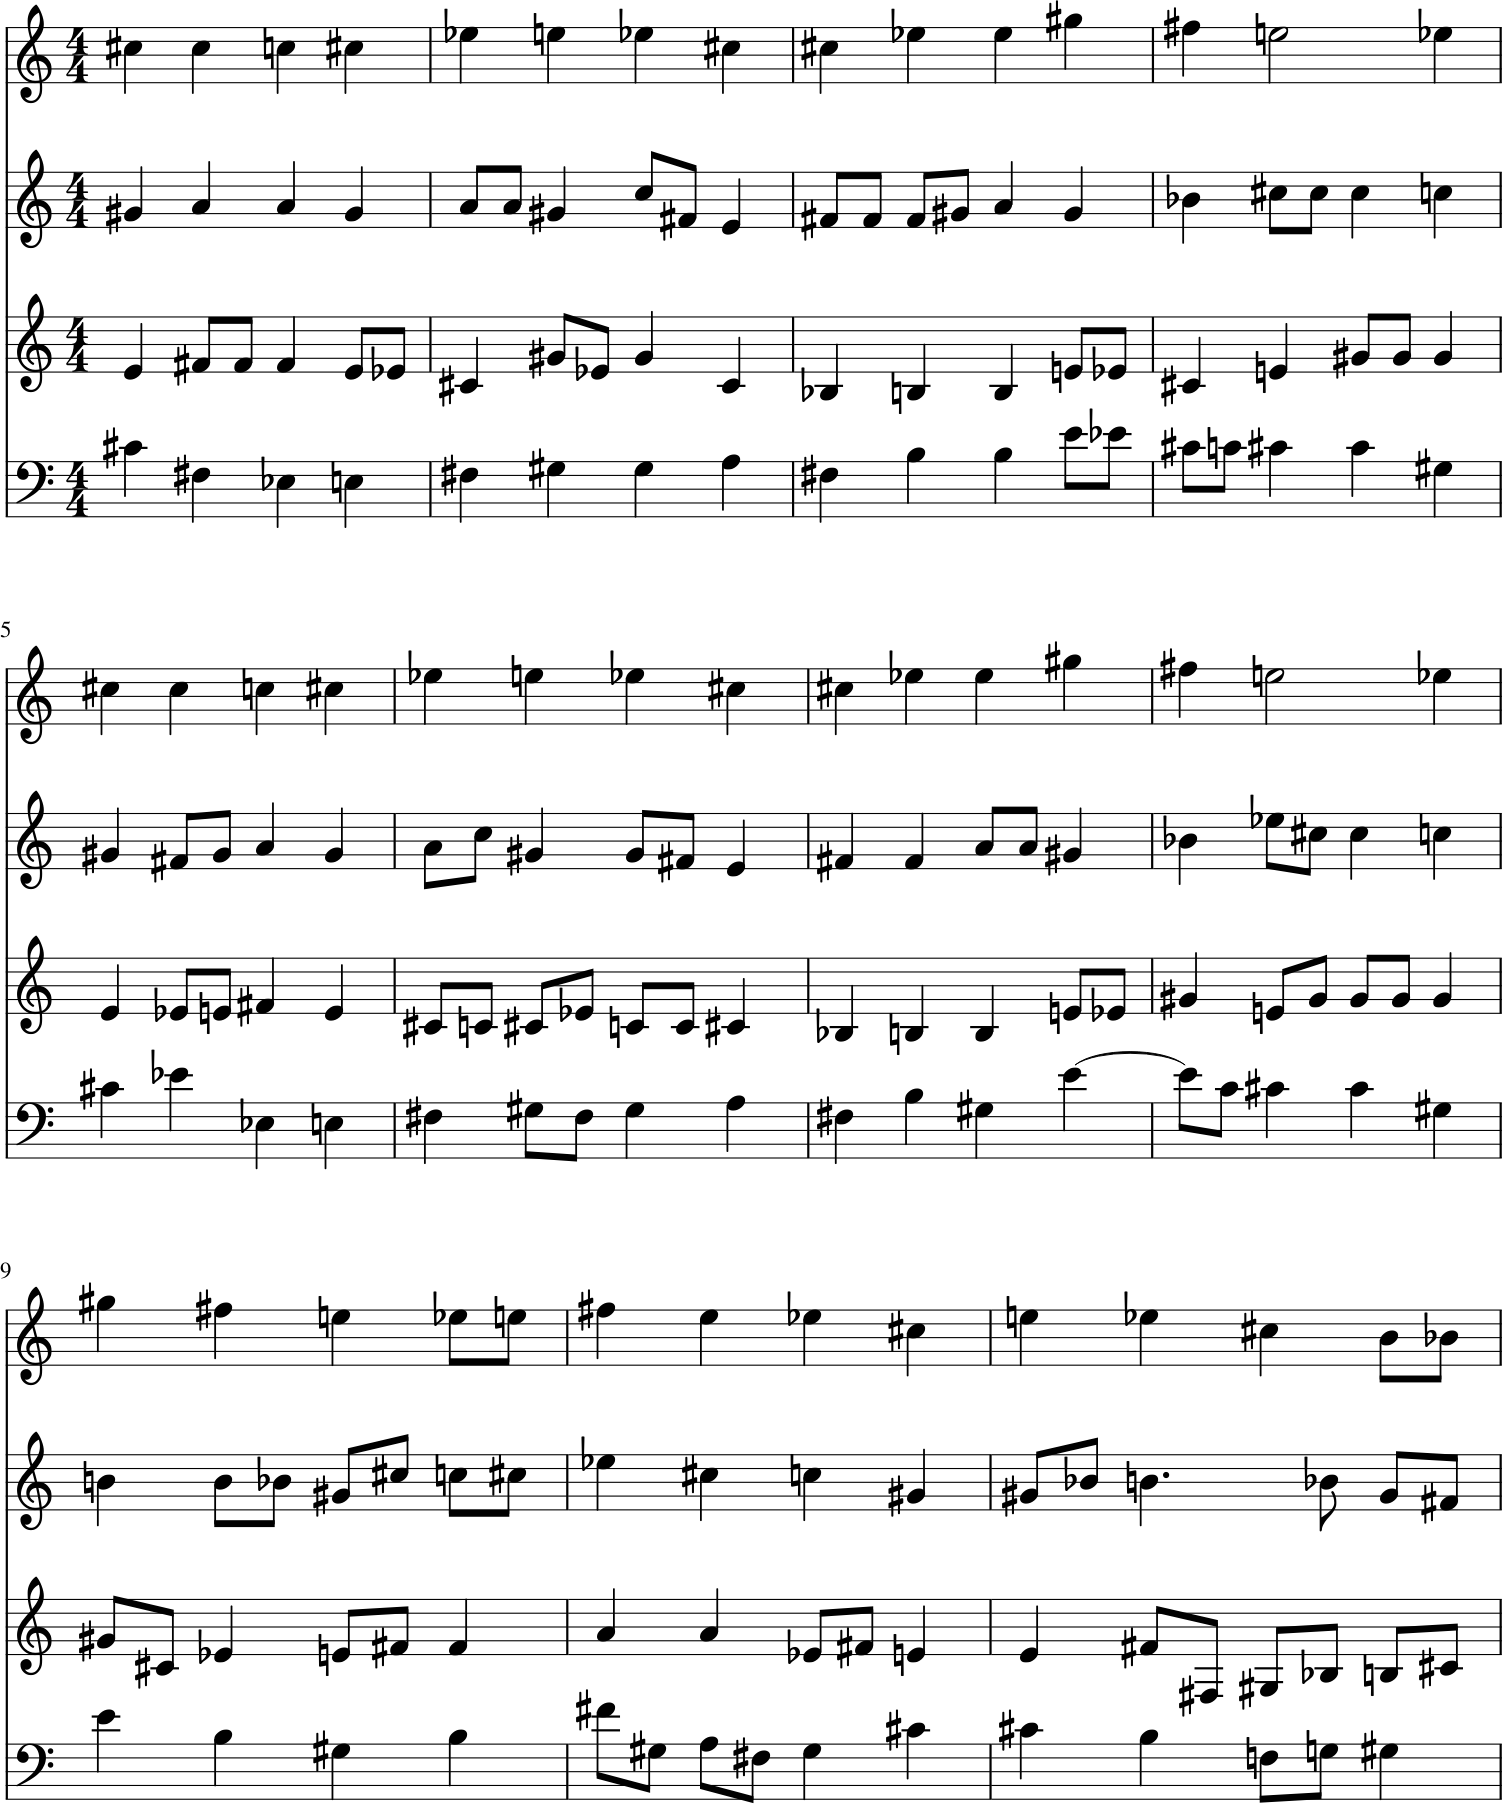

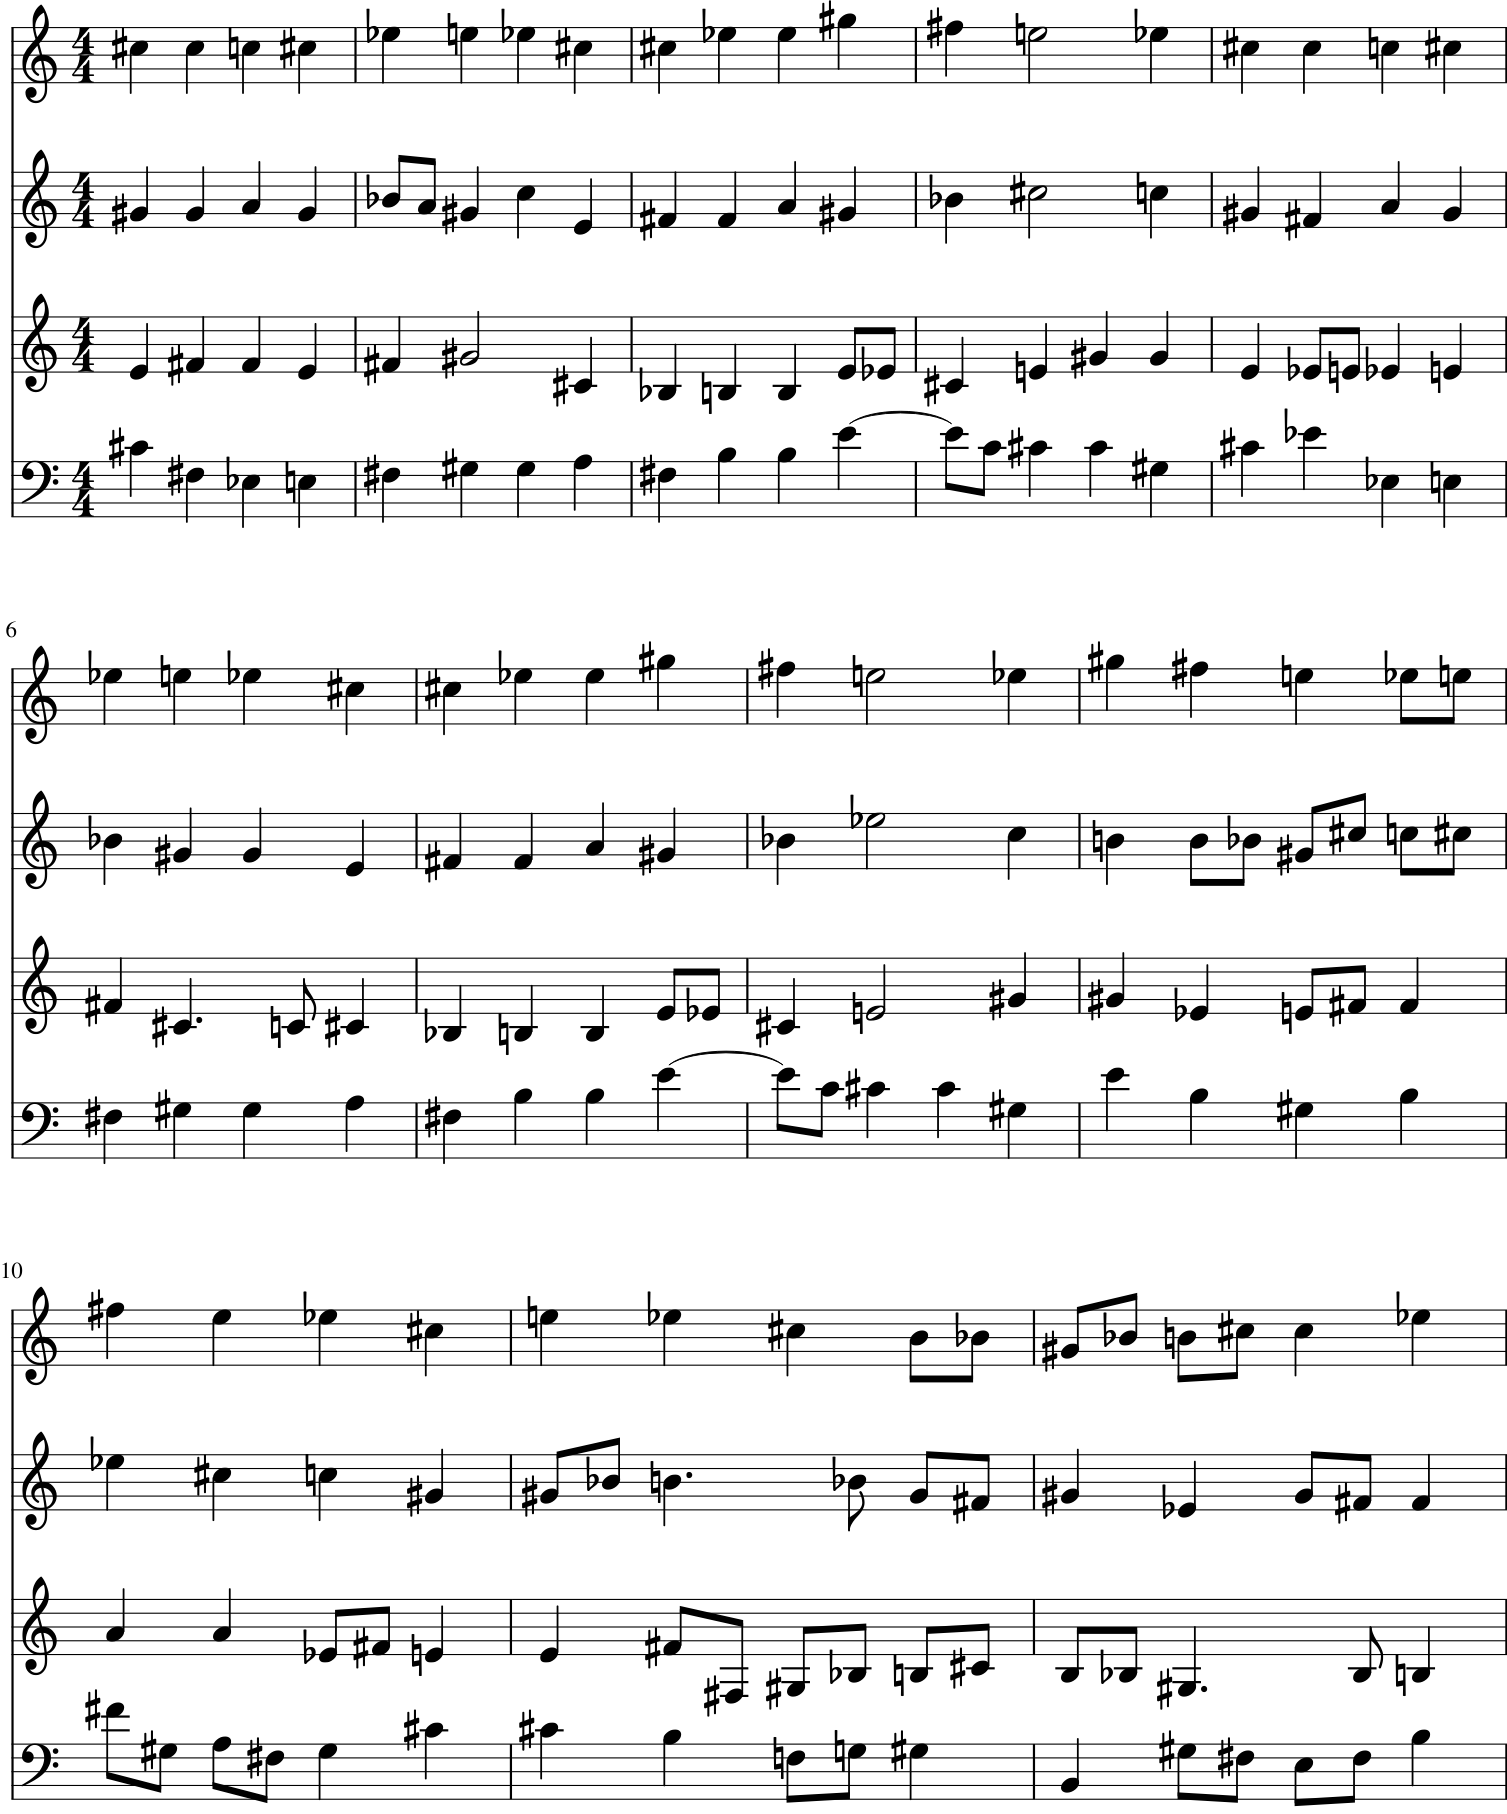

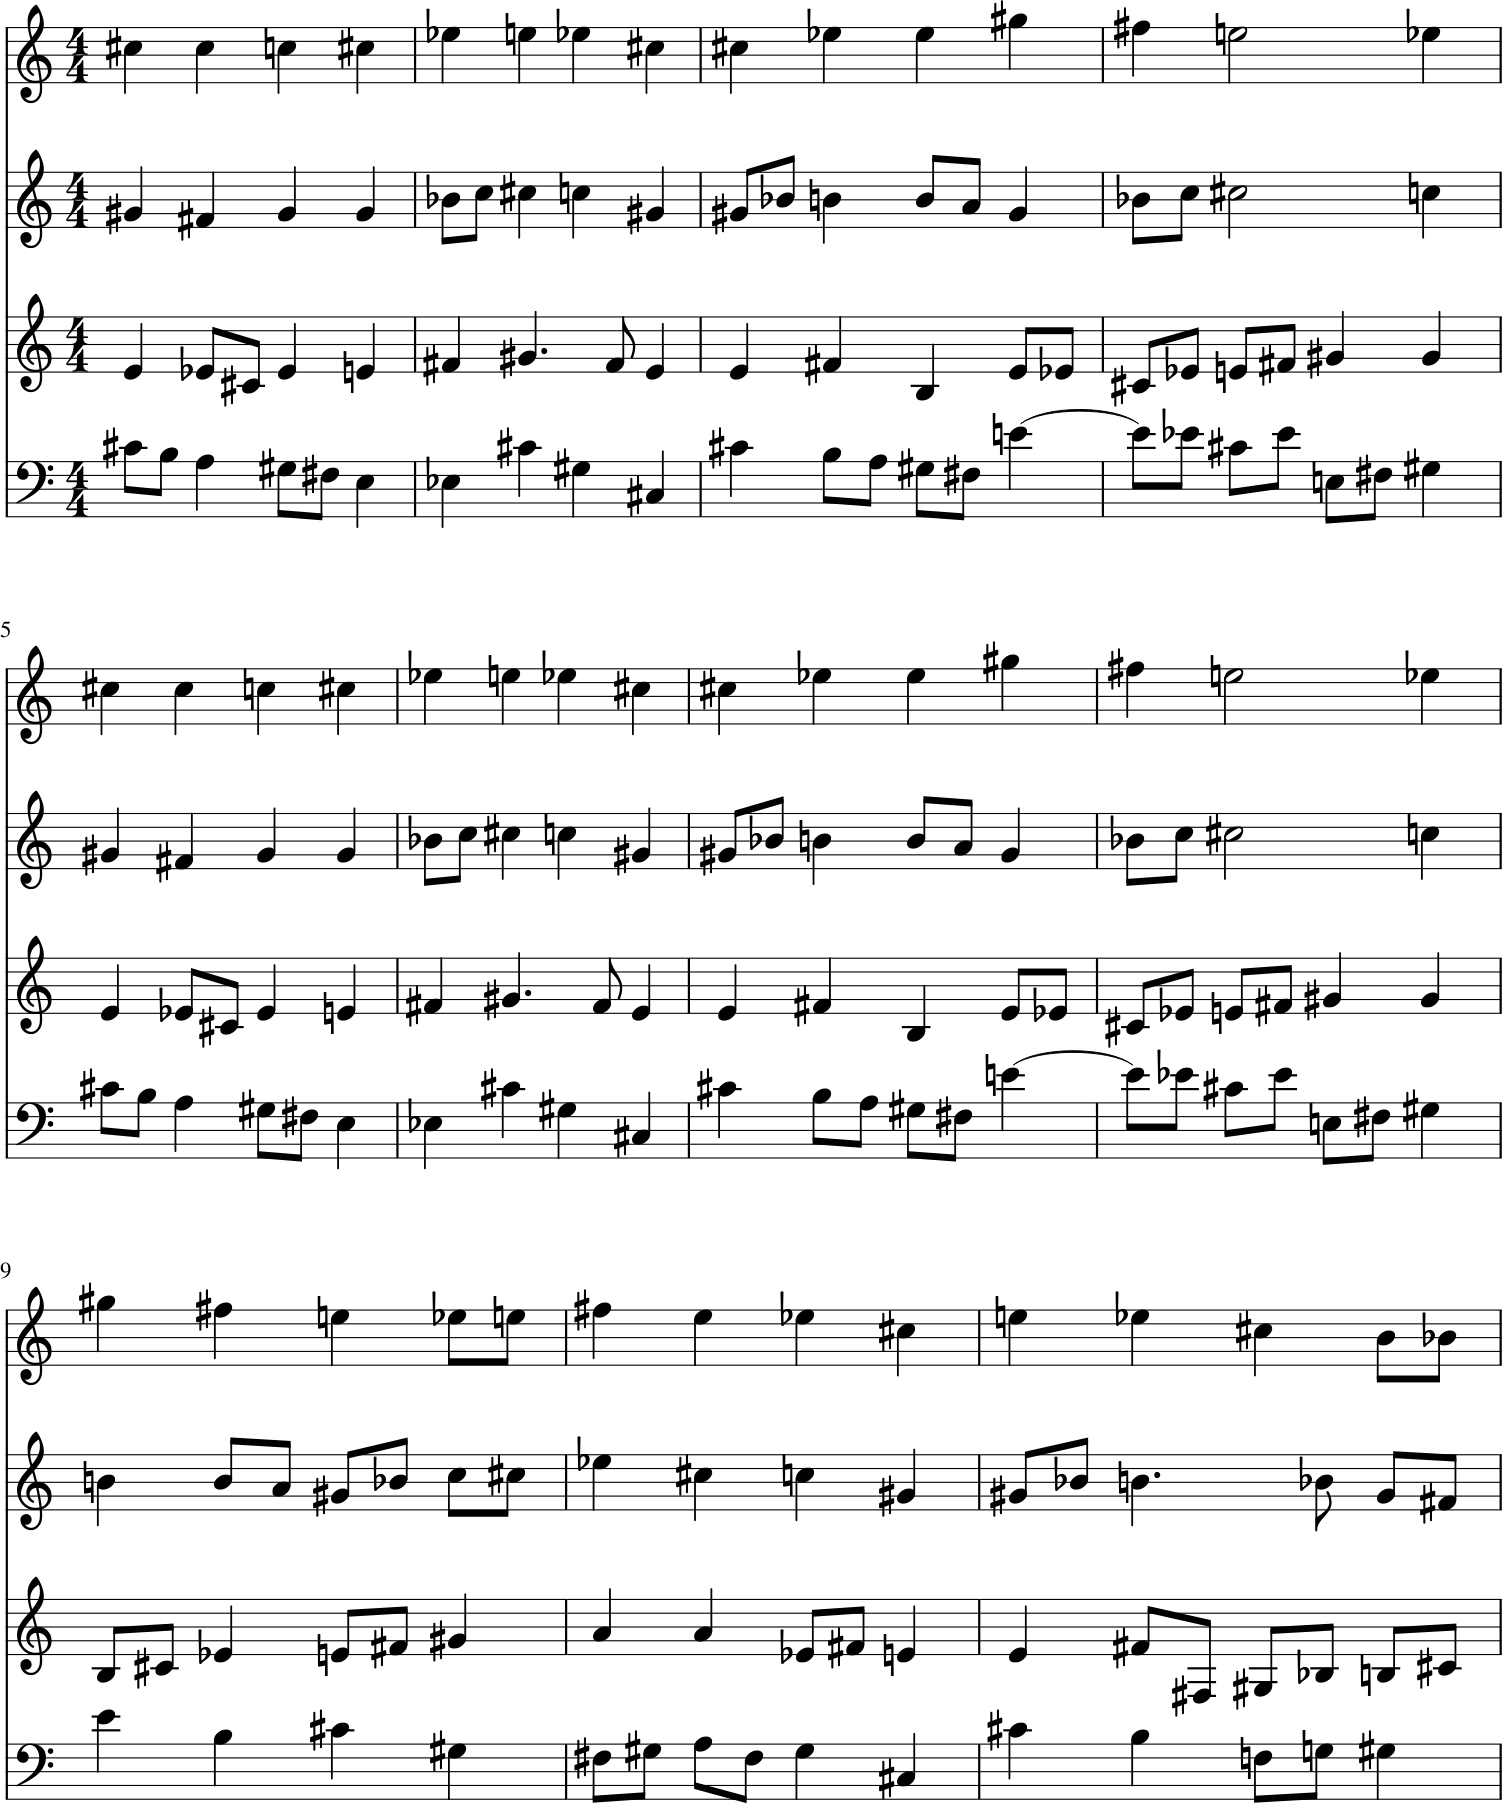

In [87]:
# 208 - 11 minor
# 190 3/4 major
songNum = 170
sc = createStream(predSongs[songNum], 4)
#print(sc.analyze('key'))
#sc.transpose(sc.analyze('key').sharps, inPlace = True)
sc.show()
sc.show('midi')
#sc.show('text')

sc = createStream(predSongsSmooth[songNum], 4)
#print(sc.analyze('key'))
#sc.transpose(sc.analyze('key').sharps, inPlace = True)
sc.show()
sc.show('midi')


sc = createStream(songs[songNum], 4)
sc.show()
sc.show('midi')



In [74]:
all_saver = tf.train.Saver()
all_saver.save(sess, '/home/lucky/models/208songsMajorMinor-2')

'/home/lucky/models/208songsMajorMinor-2'

In [11]:
print(len(songs))

98


In [58]:
all_saver = tf.train.Saver()
all_saver.restore(sess, "/home/lucky/models/98songs_4-4_4voiceAttack")


INFO:tensorflow:Restoring parameters from /home/lucky/models/98songs_4-4_4voiceAttack
